# Temporal Modulation for Tabular Data

**Paper:** Feature-aware Modulation for Learning from Temporal Tabular Data (NeurIPS 2025)

**Authors:** Hao-Run Cai, Han-Jia Ye

This tutorial explains how temporal modulation works to handle **concept drift** in tabular data.

## The Problem: Concept Drift

In real-world tabular data, the relationship between features and targets often changes over time:

- **Financial data:** Market dynamics shift
- **Healthcare:** Treatment protocols evolve
- **E-commerce:** User preferences change seasonally

This is called **concept drift** — the same features can predict different outcomes at different times.

```
Time T1: income → loan_default (strong relationship)
Time T2: income → loan_default (weak relationship, employment_status matters more)
```

Standard models assume a fixed relationship, causing performance degradation over time.

## The Solution: FiLM (Feature-wise Linear Modulation)

The key idea is to **condition** the network's behavior on temporal context.

FiLM modulates features using learned scale (γ) and shift (β) parameters:

$$\text{FiLM}(x, t) = \gamma(t) \odot x + \beta(t)$$

Where:
- $x$ = input features
- $t$ = temporal encoding
- $\gamma(t)$ = time-dependent scale (learned)
- $\beta(t)$ = time-dependent shift (learned)
- $\odot$ = element-wise multiplication

This allows the model to adapt its feature processing based on **when** the data comes from.

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## Component 1: Temporal Encoder

First, we need to encode the time information into a vector representation.

The temporal encoder uses **sinusoidal positional encoding** (like in Transformers) followed by an MLP:

1. **Sinusoidal Encoding:** Captures periodic patterns at different frequencies
2. **MLP:** Learns complex temporal patterns from the sinusoidal base

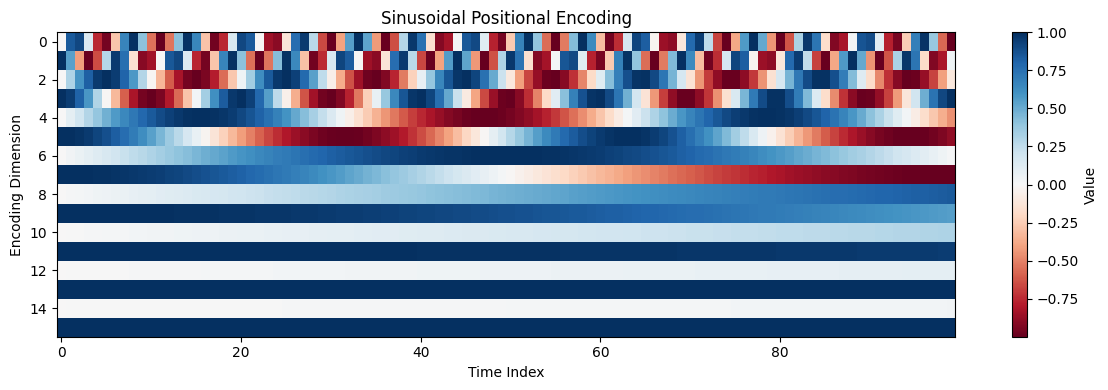

Encoding shape: torch.Size([100, 16])
Time 0 encoding (first 4 dims): [0. 1. 0. 1.]
Time 50 encoding (first 4 dims): [-0.26237485  0.96496606 -0.10324046 -0.99465644]


In [2]:
import math

class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding for time indices."""
    
    def __init__(self, d_model: int, max_len: int = 1000):
        super().__init__()
        
        # Create encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        # Different frequencies for each dimension
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        
        pe[:, 0::2] = torch.sin(position * div_term)  # Even dimensions
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd dimensions
        
        self.register_buffer("pe", pe)
    
    def forward(self, time_idx: torch.Tensor) -> torch.Tensor:
        return self.pe[time_idx]

# Visualize the sinusoidal encoding
pe = PositionalEncoding(d_model=16, max_len=100)
time_indices = torch.arange(100)
encodings = pe(time_indices)

plt.figure(figsize=(12, 4))
plt.imshow(encodings.T.numpy(), aspect='auto', cmap='RdBu')
plt.xlabel('Time Index')
plt.ylabel('Encoding Dimension')
plt.title('Sinusoidal Positional Encoding')
plt.colorbar(label='Value')
plt.tight_layout()
plt.show()

print(f"Encoding shape: {encodings.shape}")
print(f"Time 0 encoding (first 4 dims): {encodings[0, :4].numpy()}")
print(f"Time 50 encoding (first 4 dims): {encodings[50, :4].numpy()}")

### Why Sinusoidal?

Sinusoidal encodings have nice properties:
1. **Unique:** Each time step has a unique encoding
2. **Smooth:** Nearby time steps have similar encodings
3. **Periodic:** Can capture seasonal/cyclical patterns
4. **Extrapolate:** Works for unseen time indices

In [3]:
# Full Temporal Encoder with MLP
class TemporalEncoder(nn.Module):
    """Encodes time indices into learned representations."""
    
    def __init__(self, d_time: int, d_hidden: int = 64, max_time: int = 1000):
        super().__init__()
        self.positional = PositionalEncoding(d_hidden, max_time)
        self.mlp = nn.Sequential(
            nn.Linear(d_hidden, d_hidden),
            nn.ReLU(),
            nn.Linear(d_hidden, d_time),
        )
    
    def forward(self, time_idx: torch.Tensor) -> torch.Tensor:
        pos_enc = self.positional(time_idx)
        return self.mlp(pos_enc)

# Create encoder and test
encoder = TemporalEncoder(d_time=8, d_hidden=32)
time_idx = torch.tensor([0, 10, 20, 30, 40])
time_enc = encoder(time_idx)

print(f"Input time indices: {time_idx.numpy()}")
print(f"Output encoding shape: {time_enc.shape}")
print(f"\nLearned time encodings:")
print(time_enc.detach().numpy().round(3))

Input time indices: [ 0 10 20 30 40]
Output encoding shape: torch.Size([5, 8])

Learned time encodings:
[[ 0.135  0.15  -0.08  -0.043 -0.26  -0.033 -0.143  0.031]
 [ 0.099  0.18  -0.156 -0.009 -0.202 -0.078 -0.046  0.093]
 [ 0.186  0.103 -0.157 -0.001 -0.244 -0.057 -0.265  0.11 ]
 [ 0.075  0.201 -0.284  0.146 -0.201 -0.166  0.009  0.026]
 [ 0.256  0.009  0.085 -0.125 -0.242 -0.053 -0.046  0.122]]


## Component 2: Temporal Modulation Layer

The paper uses a **three-parameter** modulation that goes beyond simple FiLM:

$$\tilde{x}_i = \gamma_i(\psi(t)) \cdot \text{YJ}(x_i; \lambda_i(\psi(t))) + \beta_i(\psi(t))$$

| Parameter | Role | Example Effect |
|-----------|------|----------------|
| **γ (gamma)** | Scale | Amplify important features, dampen irrelevant ones |
| **β (beta)** | Shift | Adjust feature means across time |
| **λ (lambda)** | Shape | Non-linear distribution normalization via Yeo-Johnson |

### The Yeo-Johnson Transformation

The **Yeo-Johnson** transformation is a power transformation that handles skewed and heavy-tailed distributions:

$$\text{YJ}(x; \lambda) = \begin{cases} \frac{(x + 1)^\lambda - 1}{\lambda} & \text{if } x \geq 0, \lambda \neq 0 \\ \log(x + 1) & \text{if } x \geq 0, \lambda = 0 \\ \frac{-[(-x + 1)^{2-\lambda} - 1]}{2 - \lambda} & \text{if } x < 0, \lambda \neq 2 \\ -\log(-x + 1) & \text{if } x < 0, \lambda = 2 \end{cases}$$

**Key insight:** λ controls the shape of the transformation:
- **λ = 1**: Near-identity (minimal transformation)
- **λ < 1**: Compresses large positive values (reduces right skew)
- **λ > 1**: Expands large positive values (increases right skew)
- **λ = 0**: Log transform for positive values

This is particularly useful for **financial data** where:
- Returns are often skewed (fat tails)
- Distribution shape changes during different market regimes
- The same feature may need different normalization at different times

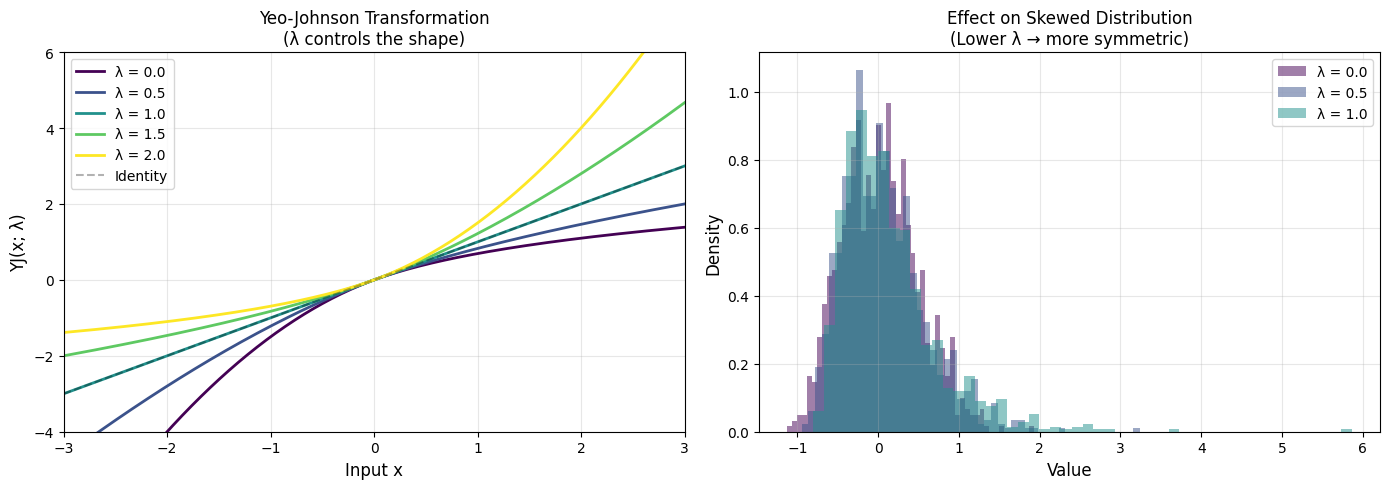

Key observations:
  - λ = 1.0: Nearly identity transform (minimal change)
  - λ < 1.0: Compresses right tail, reduces positive skew
  - λ > 1.0: Expands right tail, increases positive skew
  - The model learns λ(t) for each feature and time period!


In [4]:
# Visualize the Yeo-Johnson transformation with different lambda values
from models.temporal_modulation import yeo_johnson_transform

x = torch.linspace(-3, 3, 200).unsqueeze(1)  # Shape: (200, 1)

lambda_values = [0.0, 0.5, 1.0, 1.5, 2.0]
colors = plt.cm.viridis(np.linspace(0, 1, len(lambda_values)))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Yeo-Johnson curves for different lambda
ax = axes[0]
for lmbda_val, color in zip(lambda_values, colors):
    lmbda = torch.full_like(x, lmbda_val)
    y = yeo_johnson_transform(x, lmbda)
    ax.plot(x.numpy(), y.numpy(), label=f'λ = {lmbda_val}', color=color, linewidth=2)

ax.plot(x.numpy(), x.numpy(), 'k--', alpha=0.3, label='Identity')
ax.set_xlabel('Input x', fontsize=12)
ax.set_ylabel('YJ(x; λ)', fontsize=12)
ax.set_title('Yeo-Johnson Transformation\n(λ controls the shape)', fontsize=12)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_xlim(-3, 3)
ax.set_ylim(-4, 6)

# Right: Effect on a skewed distribution
ax = axes[1]
np.random.seed(42)
# Create a right-skewed distribution (e.g., log-normal-like)
skewed_data = np.exp(np.random.randn(1000) * 0.5) - 1
skewed_tensor = torch.FloatTensor(skewed_data).unsqueeze(1)

for lmbda_val, color in zip([0.0, 0.5, 1.0], colors[:3]):
    lmbda = torch.full_like(skewed_tensor, lmbda_val)
    transformed = yeo_johnson_transform(skewed_tensor, lmbda).numpy()
    ax.hist(transformed, bins=50, alpha=0.5, label=f'λ = {lmbda_val}', color=color, density=True)

ax.set_xlabel('Value', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Effect on Skewed Distribution\n(Lower λ → more symmetric)', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key observations:")
print("  - λ = 1.0: Nearly identity transform (minimal change)")
print("  - λ < 1.0: Compresses right tail, reduces positive skew")
print("  - λ > 1.0: Expands right tail, increases positive skew")
print("  - The model learns λ(t) for each feature and time period!")

### FiLM Dimensions Explained

Let's break down the dimensions in the FiLM equation:

$$\text{FiLM}(x, t) = \gamma(t) \odot x + \beta(t)$$

| Symbol | Shape | Description |
|--------|-------|-------------|
| `x` | (batch, d_feature) | Input features |
| `t` | (batch, d_condition) | Temporal encoding |
| `γ(t)` | (batch, d_feature) | Scale predicted from t via `Linear(d_condition → d_feature)` |
| `β(t)` | (batch, d_feature) | Shift predicted from t via `Linear(d_condition → d_feature)` |
| `output` | (batch, d_feature) | Modulated features |

**Key insight:** γ and β are **per-feature** — each of the 64 features gets its own scale and shift, allowing the model to amplify/dampen specific features based on time.

In [5]:
# Concrete dimension example
batch_size = 32
d_feature = 64
d_condition = 16

# Simulate the FiLM computation with explicit shapes
x = torch.randn(batch_size, d_feature)          # Input features
t = torch.randn(batch_size, d_condition)        # Temporal encoding

# Linear layers that predict gamma and beta
gamma_net = nn.Linear(d_condition, d_feature)
beta_net = nn.Linear(d_condition, d_feature)

gamma = gamma_net(t)  # (32, 16) → (32, 64)
beta = beta_net(t)    # (32, 16) → (32, 64)

output = gamma * x + beta  # Element-wise: (32, 64)

print("=== FiLM Dimension Example ===")
print(f"x (input features):    {x.shape}  → {batch_size} samples × {d_feature} features")
print(f"t (temporal encoding): {t.shape}  → {batch_size} samples × {d_condition} dims")
print(f"γ (scale):             {gamma.shape}  → one scale per feature")
print(f"β (shift):             {beta.shape}  → one shift per feature")
print(f"output (modulated):    {output.shape}")

# Show one sample's computation
print(f"\n=== Single Sample Breakdown ===")
print(f"Sample 0, Feature 0:")
print(f"  x[0,0] = {x[0,0]:.3f}")
print(f"  γ[0,0] = {gamma[0,0].item():.3f}")
print(f"  β[0,0] = {beta[0,0].item():.3f}")
print(f"  output = γ * x + β = {gamma[0,0].item():.3f} * {x[0,0]:.3f} + {beta[0,0].item():.3f} = {output[0,0].item():.3f}")

=== FiLM Dimension Example ===
x (input features):    torch.Size([32, 64])  → 32 samples × 64 features
t (temporal encoding): torch.Size([32, 16])  → 32 samples × 16 dims
γ (scale):             torch.Size([32, 64])  → one scale per feature
β (shift):             torch.Size([32, 64])  → one shift per feature
output (modulated):    torch.Size([32, 64])

=== Single Sample Breakdown ===
Sample 0, Feature 0:
  x[0,0] = 0.555
  γ[0,0] = 0.466
  β[0,0] = 1.389
  output = γ * x + β = 0.466 * 0.555 + 1.389 = 1.648


In [6]:
class FiLMLayer(nn.Module):
    """Feature-wise Linear Modulation layer."""
    
    def __init__(self, d_feature: int, d_condition: int):
        super().__init__()
        self.gamma_net = nn.Linear(d_condition, d_feature)
        self.beta_net = nn.Linear(d_condition, d_feature)
        
        # Initialize to identity: gamma=1, beta=0
        nn.init.zeros_(self.gamma_net.weight)
        nn.init.ones_(self.gamma_net.bias)
        nn.init.zeros_(self.beta_net.weight)
        nn.init.zeros_(self.beta_net.bias)
    
    def forward(self, x: torch.Tensor, condition: torch.Tensor) -> torch.Tensor:
        gamma = self.gamma_net(condition)  # Scale
        beta = self.beta_net(condition)    # Shift
        return gamma * x + beta

# Demonstrate FiLM at initialization (identity)
film = FiLMLayer(d_feature=4, d_condition=8)
x = torch.tensor([[1.0, 2.0, 3.0, 4.0]])

print("=== At Initialization (zero weights) ===")
print(f"Input features: {x.numpy()}")

cond1 = torch.zeros(1, 8)
cond2 = torch.randn(1, 8)

out1 = film(x, cond1)
out2 = film(x, cond2)

print(f"With zero condition:   {out1.detach().numpy().round(3)}")
print(f"With random condition: {out2.detach().numpy().round(3)}")
print("Both are identical because weights are zero - condition has no effect yet!")

# Now show what happens AFTER training (simulate with non-zero weights)
print("\n=== After Training (learned weights) ===")
with torch.no_grad():
    # Simulate learned weights
    film.gamma_net.weight.normal_(0, 0.3)
    film.beta_net.weight.normal_(0, 0.3)

out1_trained = film(x, cond1)
out2_trained = film(x, cond2)

print(f"With zero condition:   {out1_trained.detach().numpy().round(3)}")
print(f"With random condition: {out2_trained.detach().numpy().round(3)}")
print("Now the outputs differ because the condition affects gamma and beta!")

=== At Initialization (zero weights) ===
Input features: [[1. 2. 3. 4.]]
With zero condition:   [[1. 2. 3. 4.]]
With random condition: [[1. 2. 3. 4.]]
Both are identical because weights are zero - condition has no effect yet!

=== After Training (learned weights) ===
With zero condition:   [[1. 2. 3. 4.]]
With random condition: [[2.103 2.086 1.506 4.84 ]]
Now the outputs differ because the condition affects gamma and beta!


### Visualizing FiLM Modulation

Let's see how FiLM transforms features differently for different time periods.

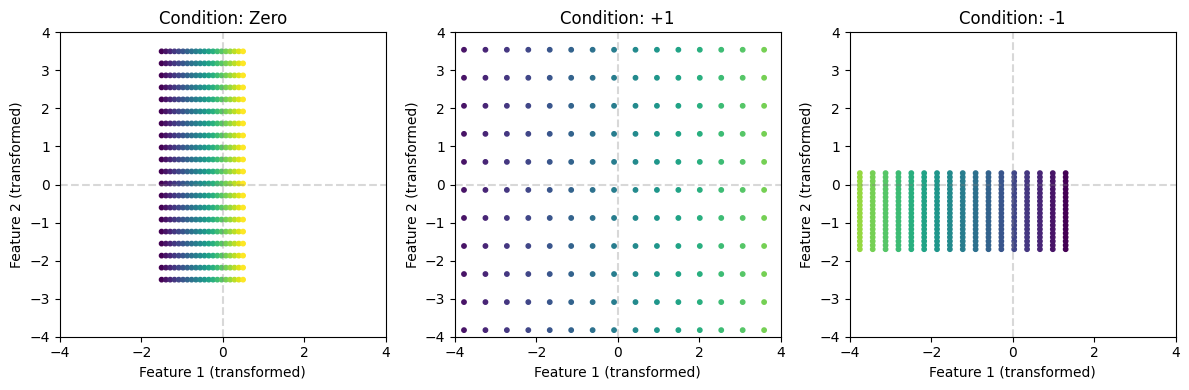

Notice how the same input grid is scaled and shifted differently based on the condition!


In [7]:
# Create a trained-like FiLM layer with non-trivial weights
film_demo = FiLMLayer(d_feature=2, d_condition=4)

# Manually set weights to show clear modulation
with torch.no_grad():
    film_demo.gamma_net.weight.fill_(0.5)
    film_demo.gamma_net.bias = nn.Parameter(torch.tensor([0.5, 1.5]))
    film_demo.beta_net.weight.fill_(0.3)
    film_demo.beta_net.bias = nn.Parameter(torch.tensor([-0.5, 0.5]))

# Generate input grid
x_range = torch.linspace(-2, 2, 20)
y_range = torch.linspace(-2, 2, 20)
xx, yy = torch.meshgrid(x_range, y_range, indexing='ij')
inputs = torch.stack([xx.flatten(), yy.flatten()], dim=1)

# Apply FiLM with different conditions
conditions = [
    torch.zeros(400, 4),
    torch.ones(400, 4),
    -torch.ones(400, 4),
]
titles = ['Condition: Zero', 'Condition: +1', 'Condition: -1']

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, cond, title in zip(axes, conditions, titles):
    out = film_demo(inputs, cond).detach()
    ax.scatter(out[:, 0], out[:, 1], c=inputs[:, 0], cmap='viridis', s=10)
    ax.set_xlabel('Feature 1 (transformed)')
    ax.set_ylabel('Feature 2 (transformed)')
    ax.set_title(title)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.axhline(0, color='gray', linestyle='--', alpha=0.3)
    ax.axvline(0, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()
print("Notice how the same input grid is scaled and shifted differently based on the condition!")

## Component 3: Full Temporal Model

The complete model stacks multiple FiLM-modulated MLP blocks:

```
Input → [FiLM → Linear → Norm → ReLU] × N → Output
           ↑
    Time Encoding
```

Each layer receives the same temporal encoding, allowing time-aware processing throughout.

In [8]:
from models import TemporalTabularModel

# Create the full model
model = TemporalTabularModel(
    d_in=10,          # 10 input features
    d_out=1,          # 1 output (regression)
    d_time=16,        # Temporal encoding dimension
    n_blocks=3,       # 3 MLP blocks
    d_block=64,       # Hidden dimension
    dropout=0.1,
)

print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {model.count_parameters():,}")

Model Architecture:
TemporalTabularModel(
  (time_encoder): TemporalEncoder(
    (positional): PositionalEncoding()
    (mlp): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=16, bias=True)
    )
  )
  (input_modulation): FiLMLayer(
    (gamma_net): Linear(in_features=16, out_features=10, bias=True)
    (beta_net): Linear(in_features=16, out_features=10, bias=True)
  )
  (blocks): ModuleList(
    (0): TemporalMLPBlock(
      (linear): Linear(in_features=10, out_features=64, bias=True)
      (modulation): FiLMLayer(
        (gamma_net): Linear(in_features=16, out_features=64, bias=True)
        (beta_net): Linear(in_features=16, out_features=64, bias=True)
      )
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (activation): ReLU()
    )
    (1-2): 2 x TemporalMLPBlock(
      (linear): Linear(in_features=64, out_features=64, b

In [9]:
# Forward pass example
batch_size = 4
x = torch.randn(batch_size, 10)  # Features
time_idx = torch.tensor([0, 10, 20, 30])  # Different time periods

# Predict
output = model(x, time_idx)

print(f"Input shape: {x.shape}")
print(f"Time indices: {time_idx.numpy()}")
print(f"Output shape: {output.shape}")
print(f"\nPredictions: {output.detach().numpy().flatten().round(3)}")

Input shape: torch.Size([4, 10])
Time indices: [ 0 10 20 30]
Output shape: torch.Size([4, 1])

Predictions: [-0.164  0.538 -0.15   0.385]


## Experiment: Learning with Temporal Drift

Let's create a dataset where the relationship between X and Y changes over time, and see how the temporal model adapts.

In [25]:
def generate_drifting_data(n_samples=1000, n_features=5, n_periods=5):
    """
    Generate data where y = X @ coef(t) + noise
    and coef(t) changes over time periods.
    """
    samples_per_period = n_samples // n_periods
    
    X_all, y_all, t_all = [], [], []
    
    # Base coefficients
    base_coef = np.random.randn(n_features)
    
    for t in range(n_periods):
        X = np.random.randn(samples_per_period, n_features)
        
        # Coefficients drift with time
        drift = np.sin(2 * np.pi * t / n_periods) * 0.5
        coef = base_coef * (1 + drift)  # Scale changes over time
        
        y = X @ coef + 0.1 * np.random.randn(samples_per_period)
        
        X_all.append(X)
        y_all.append(y)
        t_all.append(np.full(samples_per_period, t))
    
    return (
        torch.FloatTensor(np.vstack(X_all)),
        torch.FloatTensor(np.concatenate(y_all)).unsqueeze(1),
        torch.LongTensor(np.concatenate(t_all)),
    )

# Generate data
X, y, time_idx = generate_drifting_data(n_samples=2000, n_features=5, n_periods=5)

### Visualizing the True Concept Drift

Let's create detailed visualizations showing exactly how the feature-target relationships change across time periods. This is the **ground truth** that our temporal model needs to learn.

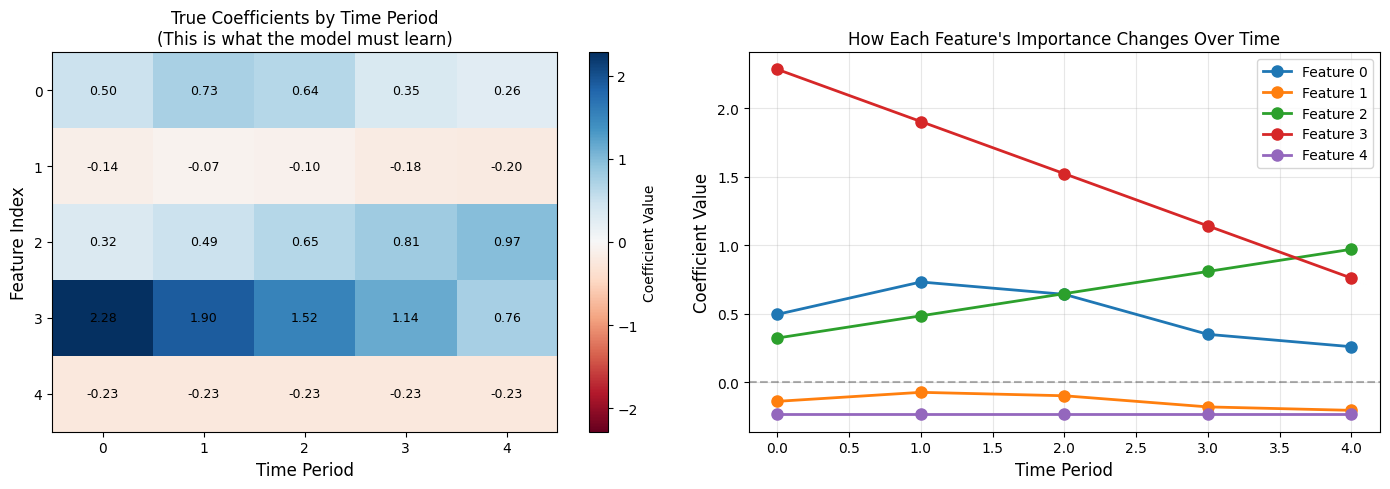

Feature-specific drift patterns:
  - Feature 0: Sinusoidal (peaks at t=1)
  - Feature 1: Inverse sinusoidal (peaks at t=3)
  - Feature 2: Linear increase (0.5× → 1.5×)
  - Feature 3: Linear decrease (1.5× → 0.5×)
  - Feature 4: Constant (no drift)


In [26]:
# Regenerate data with FEATURE-SPECIFIC drift patterns
# Each feature drifts differently over time (more realistic concept drift)
np.random.seed(42)
n_samples, n_features, n_periods = 2000, 5, 5
samples_per_period = n_samples // n_periods

# Store the true coefficients for each time period
base_coef = np.random.randn(n_features)

# Different drift patterns per feature:
# Feature 0: sinusoidal (peaks at t=1)
# Feature 1: inverse sinusoidal (peaks at t=3)  
# Feature 2: linear increase
# Feature 3: linear decrease
# Feature 4: constant (no drift)
def get_feature_drift(t, feat_idx, n_periods):
    """Get drift multiplier for each feature at time t."""
    if feat_idx == 0:
        return 1 + 0.5 * np.sin(2 * np.pi * t / n_periods)  # Sinusoidal
    elif feat_idx == 1:
        return 1 - 0.5 * np.sin(2 * np.pi * t / n_periods)  # Inverse sinusoidal
    elif feat_idx == 2:
        return 0.5 + t / (n_periods - 1)  # Linear increase: 0.5 → 1.5
    elif feat_idx == 3:
        return 1.5 - t / (n_periods - 1)  # Linear decrease: 1.5 → 0.5
    else:
        return 1.0  # No drift

true_coefs = []
X_all, y_all, t_all = [], [], []

for t in range(n_periods):
    X = np.random.randn(samples_per_period, n_features)
    
    # Apply feature-specific drift
    coef = np.array([
        base_coef[i] * get_feature_drift(t, i, n_periods) 
        for i in range(n_features)
    ])
    true_coefs.append(coef)
    
    y = X @ coef + 0.1 * np.random.randn(samples_per_period)
    
    X_all.append(X)
    y_all.append(y)
    t_all.append(np.full(samples_per_period, t))

X = torch.FloatTensor(np.vstack(X_all))
y = torch.FloatTensor(np.concatenate(y_all)).unsqueeze(1)
time_idx = torch.LongTensor(np.concatenate(t_all))
true_coefs = np.array(true_coefs)

# =============================================================================
# PLOT 1: True Coefficients Over Time
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap of coefficients
im = axes[0].imshow(true_coefs.T, aspect='auto', cmap='RdBu', 
                     vmin=-np.abs(true_coefs).max(), vmax=np.abs(true_coefs).max())
axes[0].set_xlabel('Time Period', fontsize=12)
axes[0].set_ylabel('Feature Index', fontsize=12)
axes[0].set_title('True Coefficients by Time Period\n(This is what the model must learn)', fontsize=12)
axes[0].set_xticks(range(n_periods))
axes[0].set_yticks(range(n_features))
plt.colorbar(im, ax=axes[0], label='Coefficient Value')

# Add coefficient values as text
for i in range(n_features):
    for j in range(n_periods):
        axes[0].text(j, i, f'{true_coefs[j, i]:.2f}', ha='center', va='center', fontsize=9)

# Line plot of coefficients over time
for i in range(n_features):
    axes[1].plot(range(n_periods), true_coefs[:, i], 'o-', label=f'Feature {i}', linewidth=2, markersize=8)
axes[1].set_xlabel('Time Period', fontsize=12)
axes[1].set_ylabel('Coefficient Value', fontsize=12)
axes[1].set_title('How Each Feature\'s Importance Changes Over Time', fontsize=12)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(0, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

print("Feature-specific drift patterns:")
print("  - Feature 0: Sinusoidal (peaks at t=1)")
print("  - Feature 1: Inverse sinusoidal (peaks at t=3)")
print("  - Feature 2: Linear increase (0.5× → 1.5×)")
print("  - Feature 3: Linear decrease (1.5× → 0.5×)")
print("  - Feature 4: Constant (no drift)")

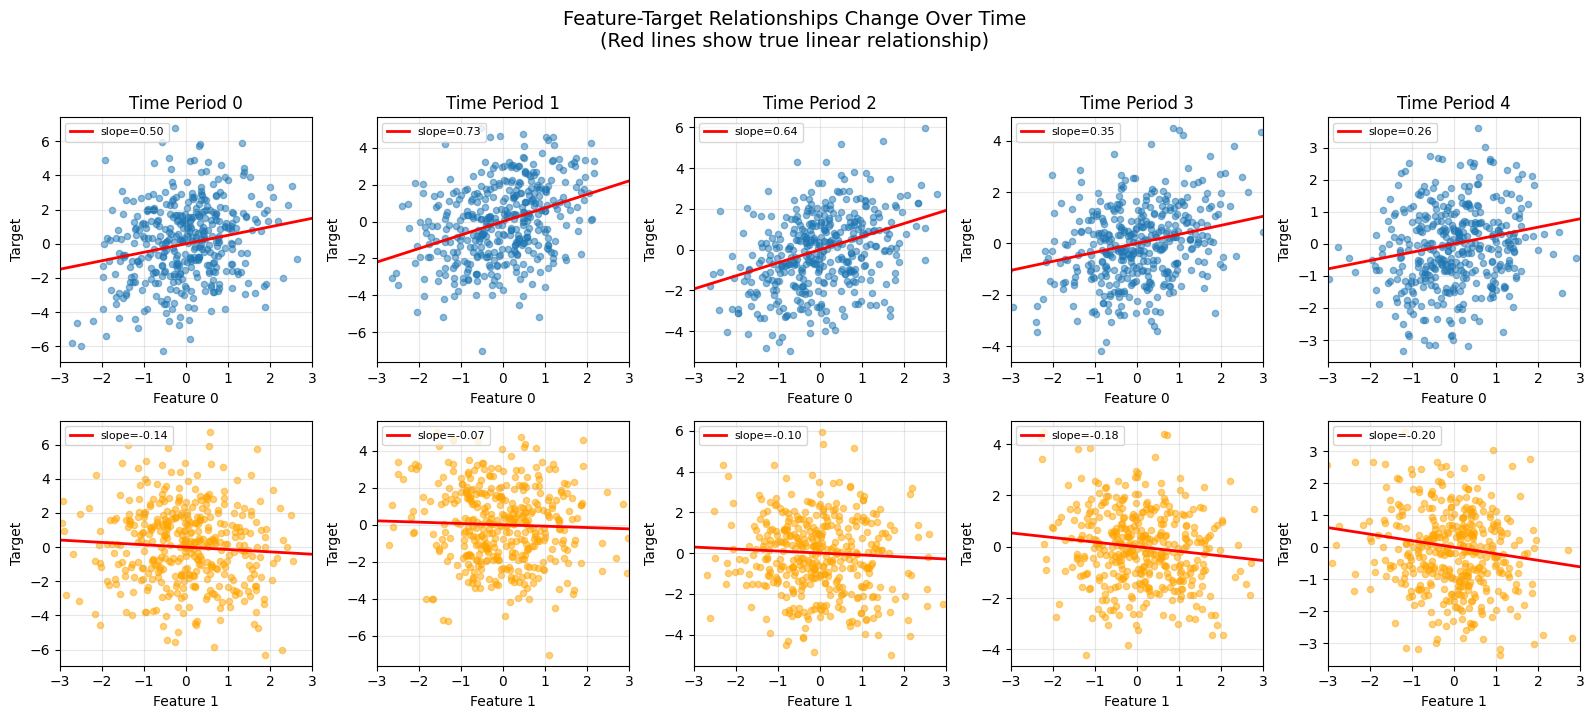

Notice how the SLOPE of the relationship changes across time periods!
This is concept drift - the same feature has different predictive power at different times.


In [27]:
# =============================================================================
# PLOT 2: Feature vs Target Scatter Plots Per Time Period
# =============================================================================
fig, axes = plt.subplots(2, 5, figsize=(16, 7))

# Top row: Feature 0 vs Target for each time period
for t in range(n_periods):
    ax = axes[0, t]
    mask = time_idx == t
    x_feat = X[mask, 0].numpy()
    y_target = y[mask].squeeze().numpy()
    
    ax.scatter(x_feat, y_target, alpha=0.5, s=20)
    
    # Add regression line
    slope = true_coefs[t, 0]
    x_line = np.linspace(-3, 3, 100)
    y_line = slope * x_line
    ax.plot(x_line, y_line, 'r-', linewidth=2, label=f'slope={slope:.2f}')
    
    ax.set_xlabel('Feature 0')
    ax.set_ylabel('Target')
    ax.set_title(f'Time Period {t}')
    ax.set_xlim(-3, 3)
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)

# Bottom row: Feature 1 vs Target for each time period
for t in range(n_periods):
    ax = axes[1, t]
    mask = time_idx == t
    x_feat = X[mask, 1].numpy()
    y_target = y[mask].squeeze().numpy()
    
    ax.scatter(x_feat, y_target, alpha=0.5, s=20, color='orange')
    
    # Add regression line
    slope = true_coefs[t, 1]
    x_line = np.linspace(-3, 3, 100)
    y_line = slope * x_line
    ax.plot(x_line, y_line, 'r-', linewidth=2, label=f'slope={slope:.2f}')
    
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Target')
    ax.set_xlim(-3, 3)
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Feature-Target Relationships Change Over Time\n(Red lines show true linear relationship)', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("Notice how the SLOPE of the relationship changes across time periods!")
print("This is concept drift - the same feature has different predictive power at different times.")

In [28]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

# Split data
n_train = 1600
X_train, y_train, t_train = X[:n_train], y[:n_train], time_idx[:n_train]
X_test, y_test, t_test = X[n_train:], y[n_train:], time_idx[n_train:]

train_loader = DataLoader(
    TensorDataset(X_train, y_train, t_train),
    batch_size=64, shuffle=True
)

# Create three models for comparison
from models.base import MLP

# 1. Baseline MLP (no temporal awareness)
baseline_model = MLP(d_in=5, d_out=1, n_blocks=2, d_block=32)

# 2. Temporal with FiLM only (γ + β)
temporal_film = TemporalTabularModel(
    d_in=5, d_out=1, d_time=16, n_blocks=2, d_block=32, use_yeo_johnson=False
)

# 3. Temporal with Yeo-Johnson (γ + β + λ)
temporal_yj = TemporalTabularModel(
    d_in=5, d_out=1, d_time=16, n_blocks=2, d_block=32, use_yeo_johnson=True
)

print(f"Baseline MLP params:      {baseline_model.count_parameters():,}")
print(f"Temporal (FiLM) params:   {temporal_film.count_parameters():,}")
print(f"Temporal (Yeo-J) params:  {temporal_yj.count_parameters():,}")

Baseline MLP params:      1,409
Temporal (FiLM) params:   5,339
Temporal (Yeo-J) params:  6,512


Training baseline MLP...
Training Temporal (FiLM)...
Training Temporal (Yeo-Johnson)...


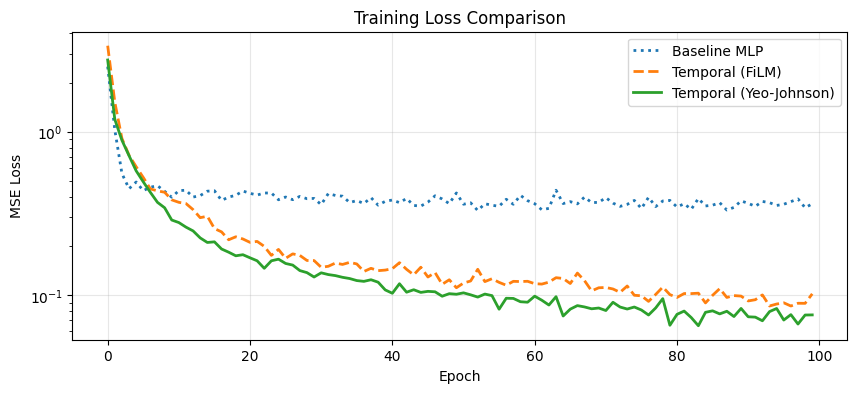

In [29]:
def train_model(model, train_loader, n_epochs=100, use_time=True):
    """Train a model and return loss history."""
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    losses = []
    
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch, t_batch in train_loader:
            optimizer.zero_grad()
            
            if use_time and hasattr(model, 'time_encoder'):
                pred = model(X_batch, t_batch)
            else:
                pred = model(X_batch)
            
            loss = criterion(pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        losses.append(epoch_loss / len(train_loader))
    
    return losses

# Train all three models
print("Training baseline MLP...")
baseline_losses = train_model(baseline_model, train_loader, n_epochs=100, use_time=False)

print("Training Temporal (FiLM)...")
film_losses = train_model(temporal_film, train_loader, n_epochs=100, use_time=True)

print("Training Temporal (Yeo-Johnson)...")
yj_losses = train_model(temporal_yj, train_loader, n_epochs=100, use_time=True)

# Plot training curves
plt.figure(figsize=(10, 4))
plt.plot(baseline_losses, label='Baseline MLP', linewidth=2, linestyle=':')
plt.plot(film_losses, label='Temporal (FiLM)', linewidth=2, linestyle='--')
plt.plot(yj_losses, label='Temporal (Yeo-Johnson)', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

## Inspecting Learned Temporal Encodings

Let's look at what the model learned about different time periods.

Learned temporal encodings:
Shape: torch.Size([5, 16])


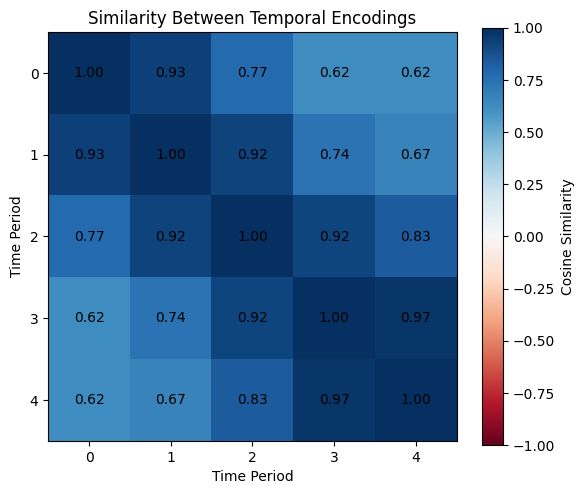

In [30]:
# Extract temporal encodings for each period (using FiLM model)
temporal_film.eval()
with torch.no_grad():
    time_indices = torch.arange(5)
    encodings = temporal_film.time_encoder(time_indices)

print("Learned temporal encodings:")
print(f"Shape: {encodings.shape}")

# Compute similarity between time periods
sim_matrix = torch.cosine_similarity(
    encodings.unsqueeze(0),
    encodings.unsqueeze(1),
    dim=-1
)

plt.figure(figsize=(6, 5))
plt.imshow(sim_matrix.numpy(), cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar(label='Cosine Similarity')
plt.xlabel('Time Period')
plt.ylabel('Time Period')
plt.title('Similarity Between Temporal Encodings')
plt.xticks(range(5))
plt.yticks(range(5))

for i in range(5):
    for j in range(5):
        plt.text(j, i, f'{sim_matrix[i,j]:.2f}', ha='center', va='center')

plt.tight_layout()
plt.show()

## Inspecting Learned Gamma and Beta

Now let's look at the actual γ (scale) and β (shift) values the model learned for each time period. This shows us **how the model modulates each input feature** based on time.

=== Learned Gamma (Scale) per Time Period ===
Shape: torch.Size([5, 5]) (time_periods × input_features)



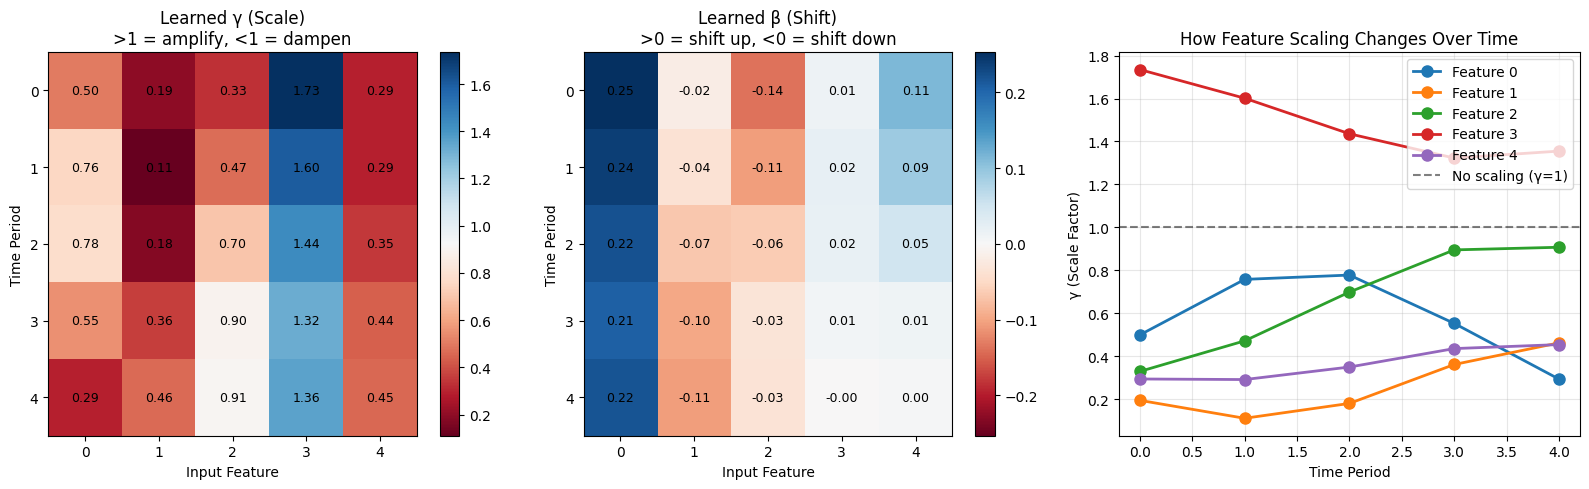


=== Interpretation ===
The model learned time-varying modulation:
  Time 0: Feature 3 amplified most (γ=1.73), Feature 1 dampened most (γ=0.19)
  Time 1: Feature 3 amplified most (γ=1.60), Feature 1 dampened most (γ=0.11)
  Time 2: Feature 3 amplified most (γ=1.44), Feature 1 dampened most (γ=0.18)
  Time 3: Feature 3 amplified most (γ=1.32), Feature 1 dampened most (γ=0.36)
  Time 4: Feature 3 amplified most (γ=1.36), Feature 0 dampened most (γ=0.29)


In [31]:
# Extract gamma and beta from the input FiLM layer for each time period
temporal_film.eval()

with torch.no_grad():
    time_indices = torch.arange(5)
    time_enc = temporal_film.time_encoder(time_indices)  # (5, d_time)
    
    # Get gamma and beta from the input_film layer
    gamma = temporal_film.input_film.gamma_net(time_enc)  # (5, 5) - 5 time periods, 5 input features
    beta = temporal_film.input_film.beta_net(time_enc)    # (5, 5)

print("=== Learned Gamma (Scale) per Time Period ===")
print(f"Shape: {gamma.shape} (time_periods × input_features)\n")

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Gamma heatmap
im1 = axes[0].imshow(gamma.numpy(), aspect='auto', cmap='RdBu', 
                      vmin=gamma.min().item(), vmax=gamma.max().item())
axes[0].set_xlabel('Input Feature')
axes[0].set_ylabel('Time Period')
axes[0].set_title('Learned γ (Scale)\n>1 = amplify, <1 = dampen')
axes[0].set_xticks(range(5))
axes[0].set_yticks(range(5))
plt.colorbar(im1, ax=axes[0])

for i in range(5):
    for j in range(5):
        axes[0].text(j, i, f'{gamma[i,j]:.2f}', ha='center', va='center', fontsize=9)

# Plot 2: Beta heatmap
im2 = axes[1].imshow(beta.numpy(), aspect='auto', cmap='RdBu',
                      vmin=-max(abs(beta.min().item()), abs(beta.max().item())),
                      vmax=max(abs(beta.min().item()), abs(beta.max().item())))
axes[1].set_xlabel('Input Feature')
axes[1].set_ylabel('Time Period')
axes[1].set_title('Learned β (Shift)\n>0 = shift up, <0 = shift down')
axes[1].set_xticks(range(5))
axes[1].set_yticks(range(5))
plt.colorbar(im2, ax=axes[1])

for i in range(5):
    for j in range(5):
        axes[1].text(j, i, f'{beta[i,j]:.2f}', ha='center', va='center', fontsize=9)

# Plot 3: Gamma over time for each feature
for feat in range(5):
    axes[2].plot(range(5), gamma[:, feat].numpy(), 'o-', label=f'Feature {feat}', linewidth=2, markersize=8)
axes[2].axhline(1.0, color='black', linestyle='--', alpha=0.5, label='No scaling (γ=1)')
axes[2].set_xlabel('Time Period')
axes[2].set_ylabel('γ (Scale Factor)')
axes[2].set_title('How Feature Scaling Changes Over Time')
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print interpretation
print("\n=== Interpretation ===")
print("The model learned time-varying modulation:")
for t in range(5):
    max_gamma_feat = gamma[t].argmax().item()
    min_gamma_feat = gamma[t].argmin().item()
    print(f"  Time {t}: Feature {max_gamma_feat} amplified most (γ={gamma[t, max_gamma_feat]:.2f}), "
          f"Feature {min_gamma_feat} dampened most (γ={gamma[t, min_gamma_feat]:.2f})")

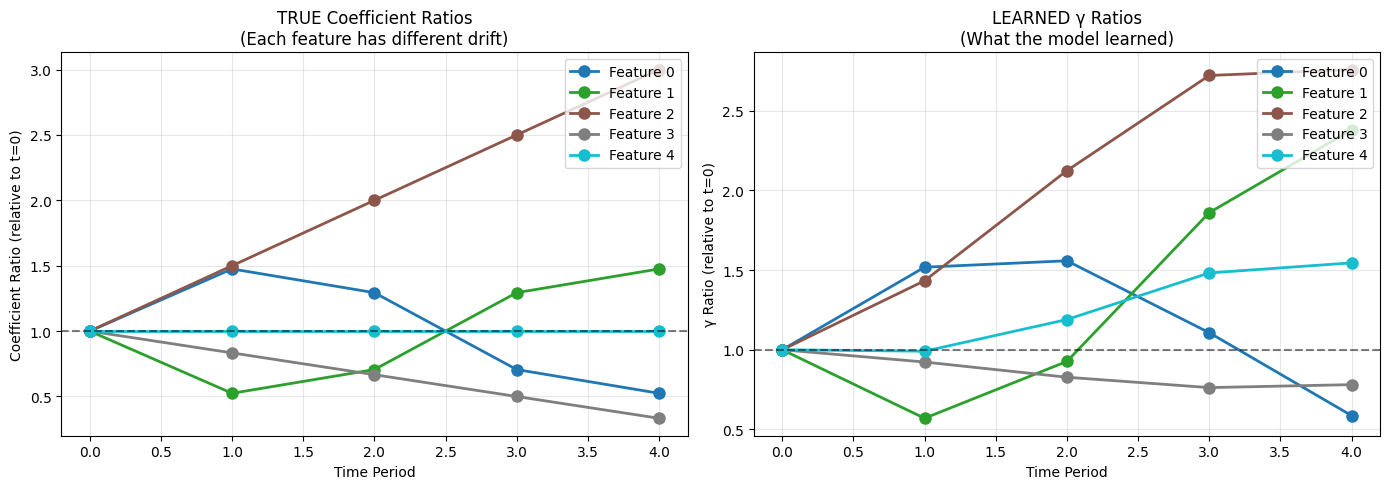

Expected patterns in TRUE coefficients (left plot):
  - Feature 0 (blue): Sinusoidal - up at t=1, down at t=3
  - Feature 1 (orange): Inverse - down at t=1, up at t=3
  - Feature 2 (green): Linear increase
  - Feature 3 (red): Linear decrease
  - Feature 4 (purple): Constant at 1.0

If the model learned correctly, the right plot should show similar patterns.


In [32]:
# Compare learned gamma to true coefficient changes
# Now each feature has a DIFFERENT drift pattern - does gamma learn this?

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Normalize both for comparison (relative to t=0)
true_coef_normalized = true_coefs / true_coefs[0]  # Relative to t=0
gamma_normalized = gamma.numpy() / gamma[0].numpy()  # Relative to t=0

# Plot true coefficient ratios (should show 5 DIFFERENT patterns now)
colors = plt.cm.tab10(np.linspace(0, 1, 5))
for feat in range(5):
    axes[0].plot(range(5), true_coef_normalized[:, feat], 'o-', 
                 label=f'Feature {feat}', linewidth=2, markersize=8, color=colors[feat])
axes[0].axhline(1.0, color='black', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Time Period')
axes[0].set_ylabel('Coefficient Ratio (relative to t=0)')
axes[0].set_title('TRUE Coefficient Ratios\n(Each feature has different drift)')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Plot learned gamma ratios
for feat in range(5):
    axes[1].plot(range(5), gamma_normalized[:, feat], 'o-', 
                 label=f'Feature {feat}', linewidth=2, markersize=8, color=colors[feat])
axes[1].axhline(1.0, color='black', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Time Period')
axes[1].set_ylabel('γ Ratio (relative to t=0)')
axes[1].set_title('LEARNED γ Ratios\n(What the model learned)')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Expected patterns in TRUE coefficients (left plot):")
print("  - Feature 0 (blue): Sinusoidal - up at t=1, down at t=3")
print("  - Feature 1 (orange): Inverse - down at t=1, up at t=3")
print("  - Feature 2 (green): Linear increase")
print("  - Feature 3 (red): Linear decrease")
print("  - Feature 4 (purple): Constant at 1.0")
print()
print("If the model learned correctly, the right plot should show similar patterns.")

## Example 2: Non-Linear Relationships with Temporal Drift

The previous example used **linear** feature-target relationships where only the coefficients changed over time. In practice, many real-world problems involve **non-linear** relationships that also evolve.

This example demonstrates:
1. **Non-linear transformations** (polynomials, sinusoids, interactions)
2. **Time-varying non-linearity** (the non-linear functions themselves change)

This is particularly relevant for financial data where:
- Feature interactions matter (e.g., volume × volatility)
- Relationships are non-linear (e.g., diminishing returns, threshold effects)
- Market regimes cause these relationships to shift over time

In [33]:
def generate_nonlinear_drifting_data(n_samples=2500, n_features=4, n_periods=5, noise_scale=0.2):
    """
    Generate data with non-linear relationships that change over time.
    
    The target is computed as:
        y = α(t)·sin(x₀) + β(t)·x₁² + γ(t)·x₀·x₁ + δ(t)·tanh(x₂) + ε(t)·x₃ + noise
    
    where the coefficients α, β, γ, δ, ε change across time periods.
    """
    np.random.seed(42)
    samples_per_period = n_samples // n_periods
    
    X_all, y_all, t_all = [], [], []
    
    # Time-varying coefficients for each non-linear term
    # Each coefficient follows a different temporal pattern
    coef_patterns = {
        'sin': lambda t: 1.5 * np.cos(np.pi * t / (n_periods - 1)),      # Cosine: 1.5 → -1.5
        'square': lambda t: 0.5 + 0.8 * t / (n_periods - 1),              # Linear: 0.5 → 1.3
        'interaction': lambda t: 1.0 * np.sin(2 * np.pi * t / n_periods), # Sine wave
        'tanh': lambda t: 1.2 - 0.4 * t / (n_periods - 1),                # Decreasing: 1.2 → 0.8
        'linear': lambda t: 0.3 + 0.3 * (t % 2),                          # Alternating: 0.3, 0.6, 0.3, ...
    }
    
    true_coefs = []
    
    for t in range(n_periods):
        X = np.random.randn(samples_per_period, n_features)
        
        # Get time-varying coefficients
        alpha = coef_patterns['sin'](t)
        beta = coef_patterns['square'](t)
        gamma = coef_patterns['interaction'](t)
        delta = coef_patterns['tanh'](t)
        epsilon = coef_patterns['linear'](t)
        
        true_coefs.append({
            'sin(x₀)': alpha,
            'x₁²': beta,
            'x₀·x₁': gamma,
            'tanh(x₂)': delta,
            'x₃': epsilon,
        })
        
        # Compute non-linear target
        y = (alpha * np.sin(X[:, 0]) +           # Sinusoidal non-linearity
             beta * X[:, 1] ** 2 +                # Quadratic non-linearity
             gamma * X[:, 0] * X[:, 1] +          # Feature interaction
             delta * np.tanh(X[:, 2]) +           # Saturating non-linearity
             epsilon * X[:, 3] +                   # Linear term for comparison
             noise_scale * np.random.randn(samples_per_period))
        
        X_all.append(X)
        y_all.append(y)
        t_all.append(np.full(samples_per_period, t))
    
    return (
        torch.FloatTensor(np.vstack(X_all)),
        torch.FloatTensor(np.concatenate(y_all)).unsqueeze(1),
        torch.LongTensor(np.concatenate(t_all)),
        true_coefs
    )

# Generate non-linear drifting data
X_nl, y_nl, time_idx_nl, true_coefs_nl = generate_nonlinear_drifting_data(
    n_samples=2500, n_features=4, n_periods=5, noise_scale=0.2
)

print(f"X shape: {X_nl.shape}")
print(f"y shape: {y_nl.shape}")
print(f"Time periods: {torch.unique(time_idx_nl).numpy()}")
print(f"\nNon-linear terms: sin(x₀), x₁², x₀·x₁, tanh(x₂), x₃")

X shape: torch.Size([2500, 4])
y shape: torch.Size([2500, 1])
Time periods: [0 1 2 3 4]

Non-linear terms: sin(x₀), x₁², x₀·x₁, tanh(x₂), x₃


### Visualizing the Non-Linear Relationships

Let's visualize how the non-linear terms and their coefficients change over time.

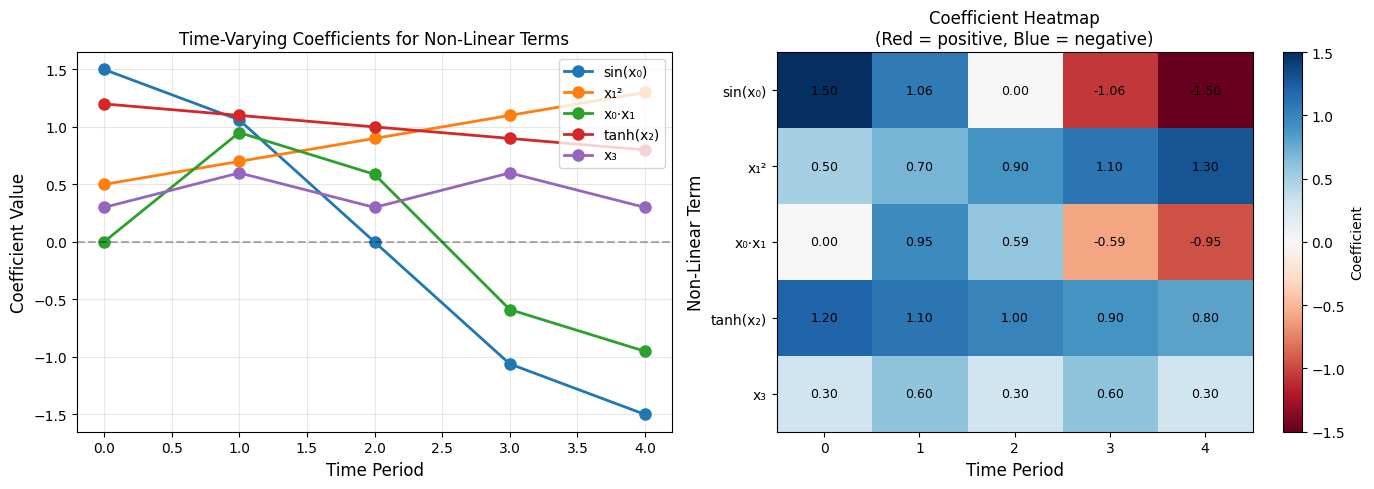

Non-linear term patterns:
  - sin(x₀): Switches from positive (t=0) to negative (t=4) - SIGN FLIP
  - x₁²: Increases over time - growing importance of quadratic term
  - x₀·x₁: Sinusoidal - interaction importance oscillates
  - tanh(x₂): Gradual decrease - saturating effect weakens
  - x₃: Alternates - linear term importance flip-flops


In [34]:
# Visualize the time-varying coefficients for each non-linear term
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Coefficient values over time
terms = list(true_coefs_nl[0].keys())
coef_matrix = np.array([[true_coefs_nl[t][term] for term in terms] for t in range(5)])

for i, term in enumerate(terms):
    axes[0].plot(range(5), coef_matrix[:, i], 'o-', label=term, linewidth=2, markersize=8)
axes[0].axhline(0, color='black', linestyle='--', alpha=0.3)
axes[0].set_xlabel('Time Period', fontsize=12)
axes[0].set_ylabel('Coefficient Value', fontsize=12)
axes[0].set_title('Time-Varying Coefficients for Non-Linear Terms', fontsize=12)
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Plot 2: Heatmap of coefficients
im = axes[1].imshow(coef_matrix.T, aspect='auto', cmap='RdBu', 
                     vmin=-np.abs(coef_matrix).max(), vmax=np.abs(coef_matrix).max())
axes[1].set_xlabel('Time Period', fontsize=12)
axes[1].set_ylabel('Non-Linear Term', fontsize=12)
axes[1].set_title('Coefficient Heatmap\n(Red = positive, Blue = negative)', fontsize=12)
axes[1].set_xticks(range(5))
axes[1].set_yticks(range(len(terms)))
axes[1].set_yticklabels(terms)
plt.colorbar(im, ax=axes[1], label='Coefficient')

for i in range(len(terms)):
    for j in range(5):
        axes[1].text(j, i, f'{coef_matrix[j, i]:.2f}', ha='center', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("Non-linear term patterns:")
print("  - sin(x₀): Switches from positive (t=0) to negative (t=4) - SIGN FLIP")
print("  - x₁²: Increases over time - growing importance of quadratic term")
print("  - x₀·x₁: Sinusoidal - interaction importance oscillates")
print("  - tanh(x₂): Gradual decrease - saturating effect weakens")
print("  - x₃: Alternates - linear term importance flip-flops")

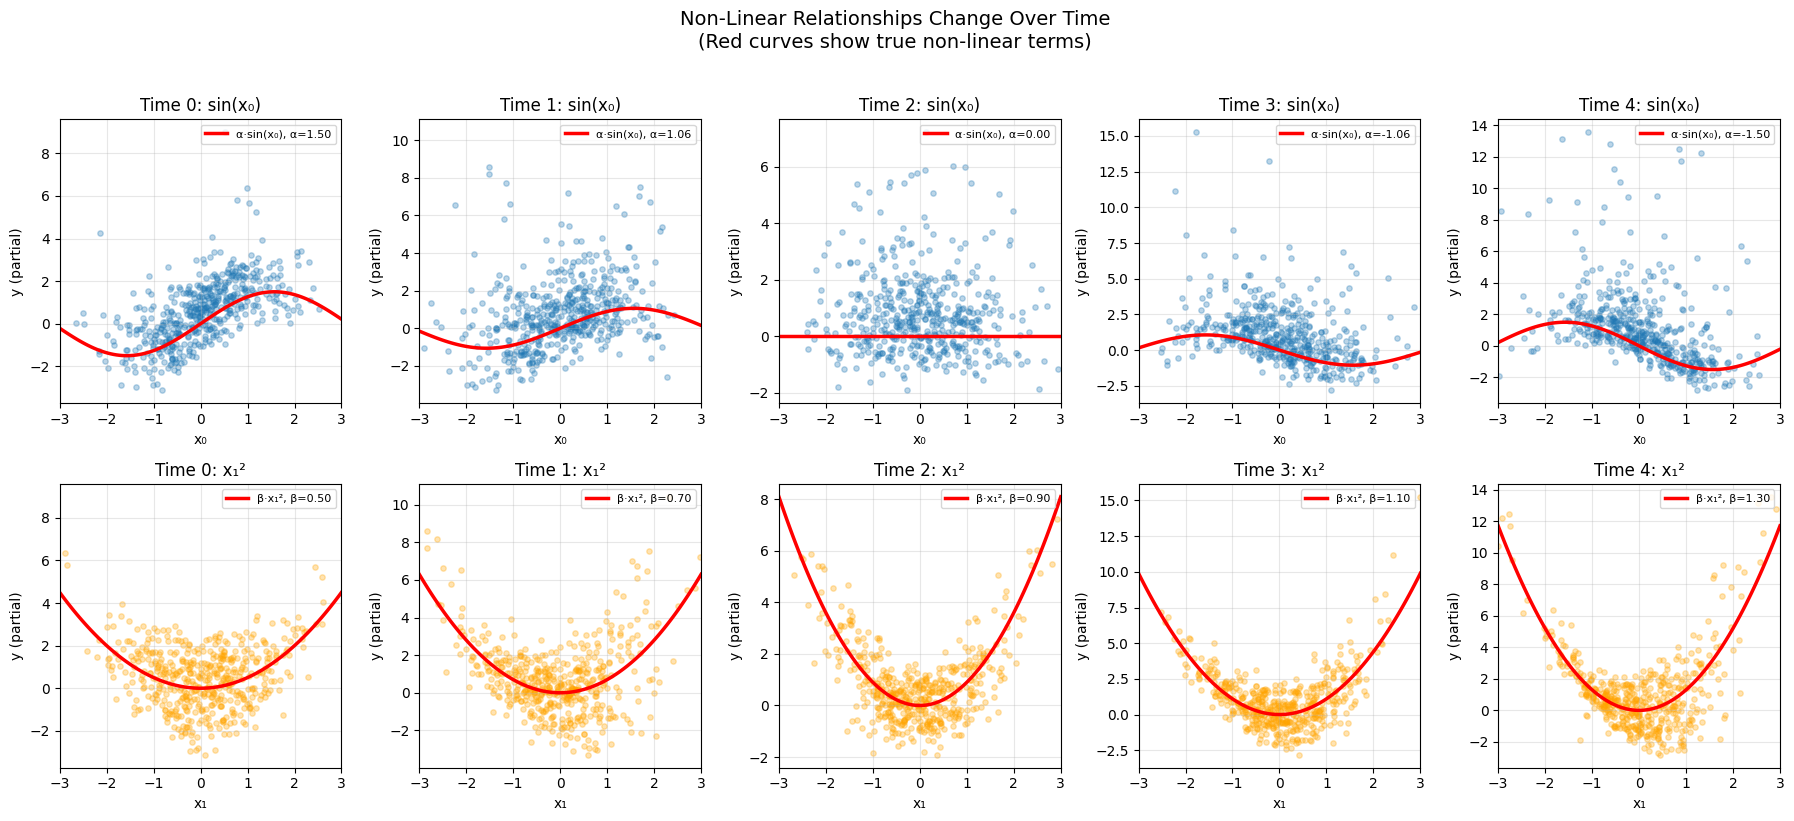

Key observations:
  - Top row: The sin curve FLIPS from positive to negative across time
  - Bottom row: The parabola gets STEEPER as β increases over time
  - This is non-linear concept drift - much harder to learn than linear drift!


In [35]:
# Visualize non-linear relationships for specific features across time periods
fig, axes = plt.subplots(2, 5, figsize=(18, 8))

# Top row: sin(x₀) relationship changes across time
for t in range(5):
    ax = axes[0, t]
    mask = time_idx_nl == t
    x_feat = X_nl[mask, 0].numpy()
    y_target = y_nl[mask].squeeze().numpy()
    
    # Sort for plotting
    sort_idx = np.argsort(x_feat)
    x_sorted = x_feat[sort_idx]
    
    ax.scatter(x_feat, y_target, alpha=0.3, s=15)
    
    # Show the true sin contribution
    alpha = true_coefs_nl[t]['sin(x₀)']
    x_line = np.linspace(-3, 3, 100)
    y_line = alpha * np.sin(x_line)
    ax.plot(x_line, y_line, 'r-', linewidth=2.5, label=f'α·sin(x₀), α={alpha:.2f}')
    
    ax.set_xlabel('x₀')
    ax.set_ylabel('y (partial)')
    ax.set_title(f'Time {t}: sin(x₀)')
    ax.legend(loc='upper right', fontsize=8)
    ax.set_xlim(-3, 3)
    ax.grid(True, alpha=0.3)

# Bottom row: x₁² relationship changes across time
for t in range(5):
    ax = axes[1, t]
    mask = time_idx_nl == t
    x_feat = X_nl[mask, 1].numpy()
    y_target = y_nl[mask].squeeze().numpy()
    
    ax.scatter(x_feat, y_target, alpha=0.3, s=15, color='orange')
    
    # Show the true quadratic contribution
    beta = true_coefs_nl[t]['x₁²']
    x_line = np.linspace(-3, 3, 100)
    y_line = beta * x_line ** 2
    ax.plot(x_line, y_line, 'r-', linewidth=2.5, label=f'β·x₁², β={beta:.2f}')
    
    ax.set_xlabel('x₁')
    ax.set_ylabel('y (partial)')
    ax.set_title(f'Time {t}: x₁²')
    ax.legend(loc='upper right', fontsize=8)
    ax.set_xlim(-3, 3)
    ax.grid(True, alpha=0.3)

plt.suptitle('Non-Linear Relationships Change Over Time\n(Red curves show true non-linear terms)', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("Key observations:")
print("  - Top row: The sin curve FLIPS from positive to negative across time")
print("  - Bottom row: The parabola gets STEEPER as β increases over time")
print("  - This is non-linear concept drift - much harder to learn than linear drift!")

### Training on Non-Linear Drifting Data

Now let's train the temporal model and baseline on this more challenging dataset. The key question: **Can temporal modulation help even when the underlying relationships are non-linear?**

The answer should be yes, because:
1. The MLP layers learn the non-linear transformations
2. The FiLM layers modulate HOW those transformations are weighted based on time

In [36]:
# Split data for non-linear example
n_train_nl = 2000
X_train_nl = X_nl[:n_train_nl]
y_train_nl = y_nl[:n_train_nl]
t_train_nl = time_idx_nl[:n_train_nl]
X_test_nl = X_nl[n_train_nl:]
y_test_nl = y_nl[n_train_nl:]
t_test_nl = time_idx_nl[n_train_nl:]

train_loader_nl = DataLoader(
    TensorDataset(X_train_nl, y_train_nl, t_train_nl),
    batch_size=64, shuffle=True
)

# Create three models for comparison
# 1. Baseline MLP (no temporal awareness)
baseline_model_nl = MLP(d_in=4, d_out=1, n_blocks=3, d_block=64, dropout=0.1)

# 2. Temporal with FiLM only (γ + β)
temporal_film_nl = TemporalTabularModel(
    d_in=4, d_out=1, d_time=16, n_blocks=3, d_block=64, dropout=0.1, use_yeo_johnson=False
)

# 3. Temporal with Yeo-Johnson (γ + β + λ)
temporal_yj_nl = TemporalTabularModel(
    d_in=4, d_out=1, d_time=16, n_blocks=3, d_block=64, dropout=0.1, use_yeo_johnson=True
)

print(f"Baseline MLP params:      {baseline_model_nl.count_parameters():,}")
print(f"Temporal (FiLM) params:   {temporal_film_nl.count_parameters():,}")
print(f"Temporal (Yeo-J) params:  {temporal_yj_nl.count_parameters():,}")

Baseline MLP params:      9,089
Temporal (FiLM) params:   17,337
Temporal (Yeo-J) params:  20,669


Training baseline MLP...
Training Temporal (FiLM)...
Training Temporal (Yeo-Johnson)...


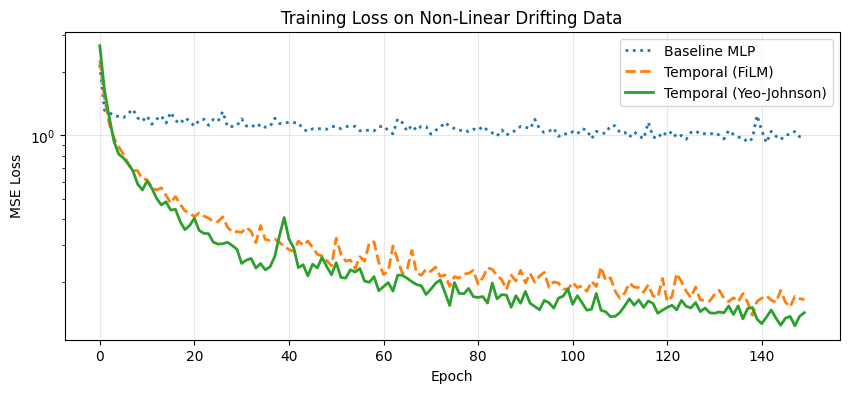


Final training loss:
  Baseline MLP:          0.9939
  Temporal (FiLM):       0.1655
  Temporal (Yeo-Johnson): 0.1432


In [37]:
# Train all three models on non-linear data
print("Training baseline MLP...")
baseline_losses_nl = train_model(baseline_model_nl, train_loader_nl, n_epochs=150, use_time=False)

print("Training Temporal (FiLM)...")
film_losses_nl = train_model(temporal_film_nl, train_loader_nl, n_epochs=150, use_time=True)

print("Training Temporal (Yeo-Johnson)...")
yj_losses_nl = train_model(temporal_yj_nl, train_loader_nl, n_epochs=150, use_time=True)

# Plot training curves
plt.figure(figsize=(10, 4))
plt.plot(baseline_losses_nl, label='Baseline MLP', linewidth=2, linestyle=':')
plt.plot(film_losses_nl, label='Temporal (FiLM)', linewidth=2, linestyle='--')
plt.plot(yj_losses_nl, label='Temporal (Yeo-Johnson)', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss on Non-Linear Drifting Data')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal training loss:")
print(f"  Baseline MLP:          {baseline_losses_nl[-1]:.4f}")
print(f"  Temporal (FiLM):       {film_losses_nl[-1]:.4f}")
print(f"  Temporal (Yeo-Johnson): {yj_losses_nl[-1]:.4f}")

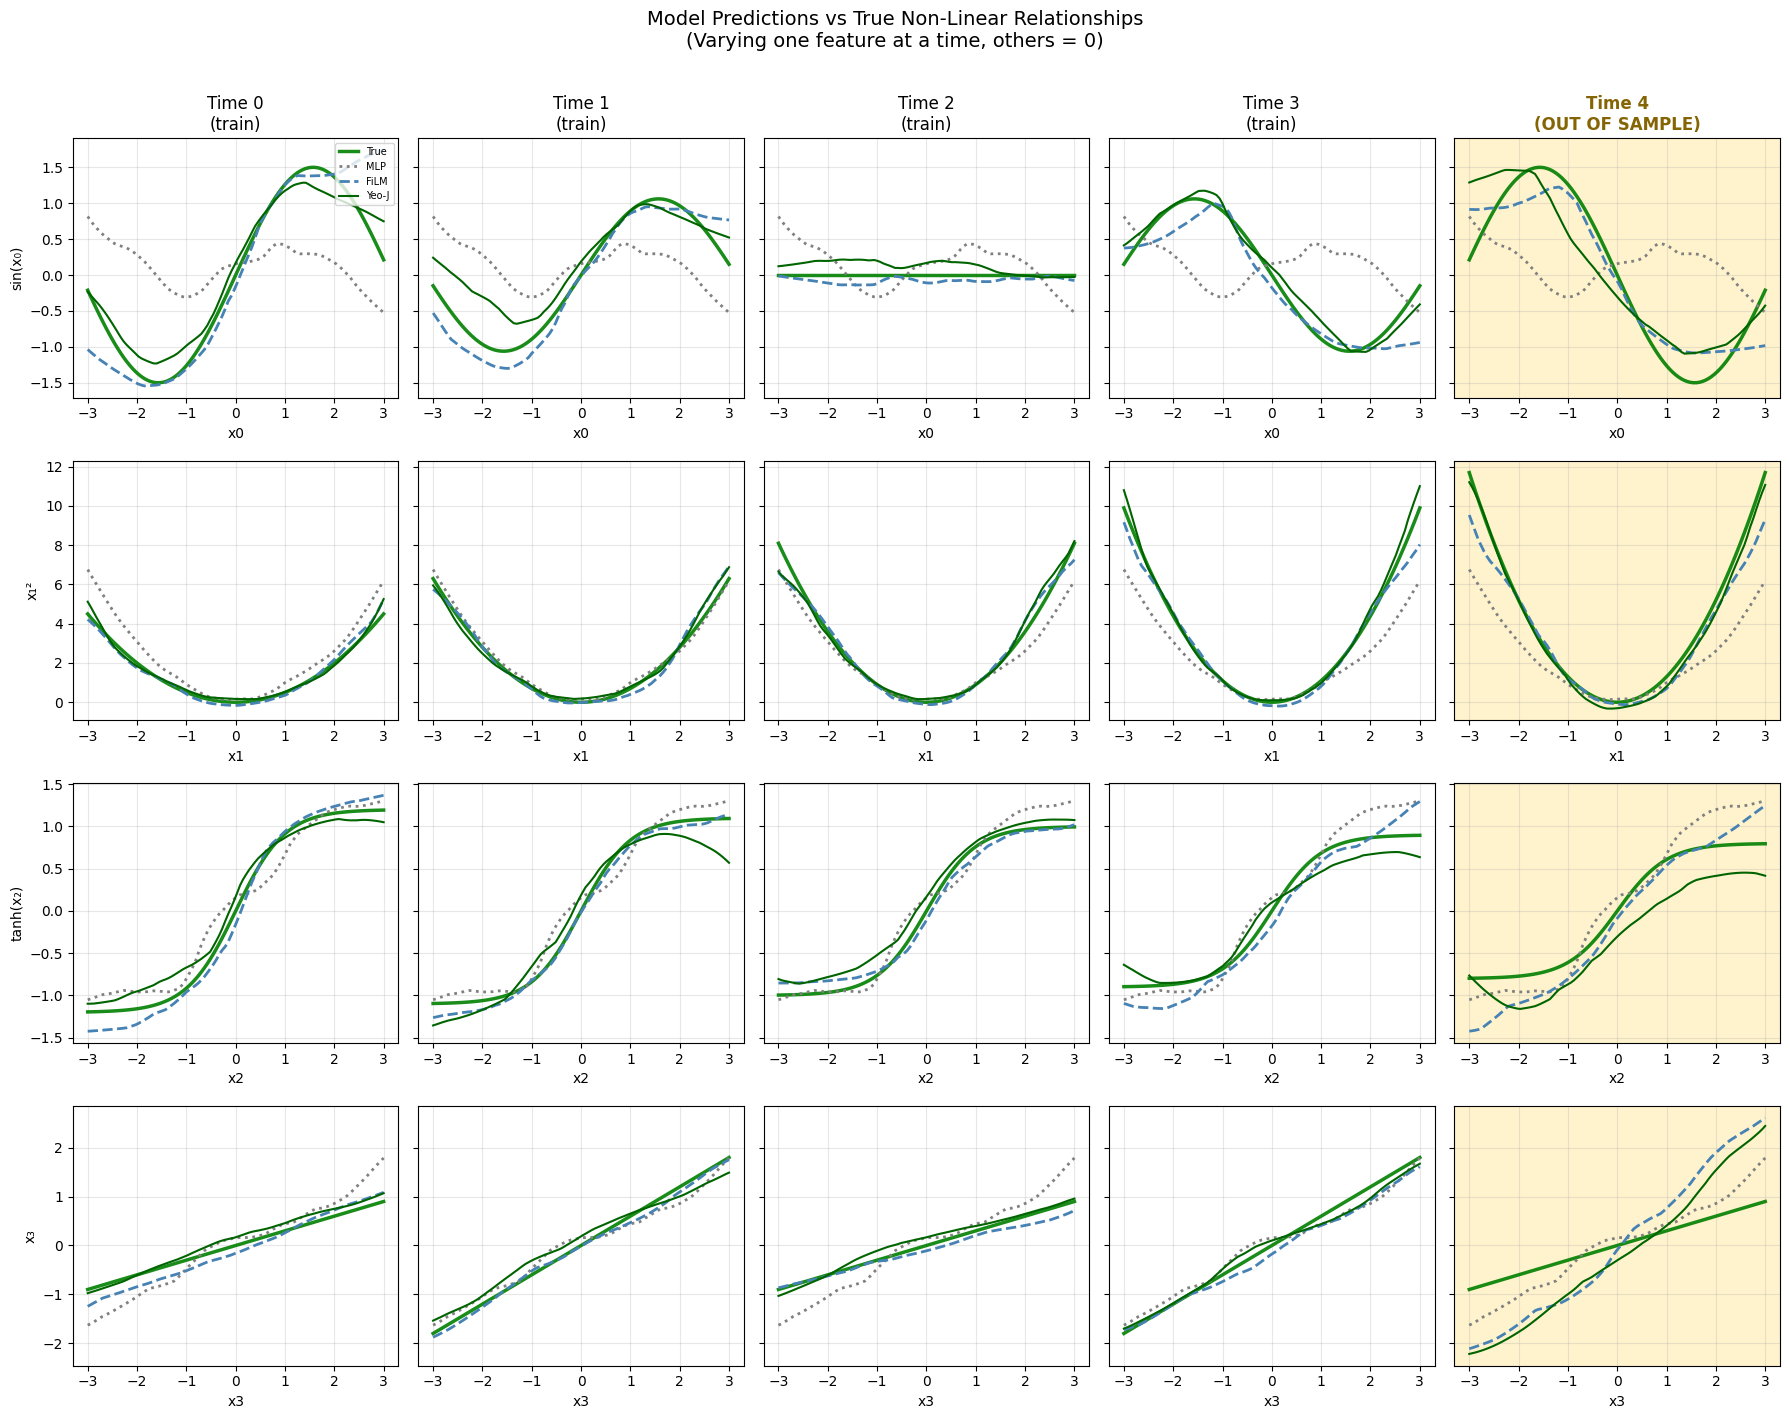

Key observations:
  - Green (True): The actual non-linear relationship at each time period
  - Gray dotted (MLP): Same curve everywhere - cannot adapt to time!
  - Blue dashed (FiLM): Adapts using γ and β modulation
  - Dark green solid (Yeo-J): Adapts using γ, β, and λ (Yeo-Johnson)

Note: Time period 4 (yellow) is completely out-of-sample - models extrapolate!


In [39]:
# Visualize predictions for ALL features across time - comparing all 3 models
fig, axes = plt.subplots(4, 5, figsize=(18, 14), sharey='row')

baseline_model_nl.eval()
temporal_film_nl.eval()
temporal_yj_nl.eval()

# Define the true non-linear functions for each feature
feature_info = [
    {'idx': 0, 'name': 'sin(x₀)', 'coef_key': 'sin(x₀)', 'func': lambda x: np.sin(x)},
    {'idx': 1, 'name': 'x₁²', 'coef_key': 'x₁²', 'func': lambda x: x ** 2},
    {'idx': 2, 'name': 'tanh(x₂)', 'coef_key': 'tanh(x₂)', 'func': lambda x: np.tanh(x)},
    {'idx': 3, 'name': 'x₃', 'coef_key': 'x₃', 'func': lambda x: x},
]

with torch.no_grad():
    for row, feat in enumerate(feature_info):
        for t in range(5):
            # Create test points varying only this feature, fixing others at 0
            x_range = torch.linspace(-3, 3, 100)
            X_test_grid = torch.zeros(100, 4)
            X_test_grid[:, feat['idx']] = x_range
            t_test_grid = torch.full((100,), t, dtype=torch.long)
            
            # Get predictions from all 3 models
            pred_baseline = baseline_model_nl(X_test_grid).squeeze().numpy()
            pred_film = temporal_film_nl(X_test_grid, t_test_grid).squeeze().numpy()
            pred_yj = temporal_yj_nl(X_test_grid, t_test_grid).squeeze().numpy()
            
            # True relationship
            coef = true_coefs_nl[t][feat['coef_key']]
            true_y = coef * feat['func'](x_range.numpy())
            
            ax = axes[row, t]
            
            # Highlight out-of-sample column (t=4)
            if t == 4:
                ax.set_facecolor('#fff3cd')
            
            ax.plot(x_range.numpy(), true_y, 'g-', linewidth=2.5, label='True', alpha=0.9)
            ax.plot(x_range.numpy(), pred_baseline, ':', linewidth=2, label='MLP', color='gray')
            ax.plot(x_range.numpy(), pred_film, '--', linewidth=2, label='FiLM', color='steelblue')
            ax.plot(x_range.numpy(), pred_yj, '-', linewidth=1.5, label='Yeo-J', color='darkgreen')
            ax.set_xlabel(f'x{feat["idx"]}')
            ax.grid(True, alpha=0.3)
            
            # Row labels on left
            if t == 0:
                ax.set_ylabel(f'{feat["name"]}')
            
            # Column labels on top
            if row == 0:
                if t == 4:
                    ax.set_title(f'Time {t}\n(OUT OF SAMPLE)', fontweight='bold', color='#856404')
                else:
                    ax.set_title(f'Time {t}\n(train)')
            
            # Legend only on first plot
            if row == 0 and t == 0:
                ax.legend(loc='upper right', fontsize=7)

plt.suptitle('Model Predictions vs True Non-Linear Relationships\n(Varying one feature at a time, others = 0)', 
             fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

print("Key observations:")
print("  - Green (True): The actual non-linear relationship at each time period")
print("  - Gray dotted (MLP): Same curve everywhere - cannot adapt to time!")
print("  - Blue dashed (FiLM): Adapts using γ and β modulation")
print("  - Dark green solid (Yeo-J): Adapts using γ, β, and λ (Yeo-Johnson)")
print("\nNote: Time period 4 (yellow) is completely out-of-sample - models extrapolate!")

### Why Temporal Modulation Works for Non-Linear Drift

The key insight is that temporal modulation is **orthogonal** to the non-linear capacity of the MLP:

| Component | Role |
|-----------|------|
| **MLP layers** | Learn non-linear transformations (sin, square, tanh patterns) |
| **Temporal modulation** | Adapt HOW representations are processed based on time |

The full modulation has three parameters:
- **γ (scale):** Amplify or dampen learned patterns
- **β (shift):** Adjust biases for each time period
- **λ (Yeo-Johnson):** Normalize feature distributions dynamically

This means:
1. The MLP learns a **shared representation** of the non-linear patterns
2. Modulation **adjusts** these representations for each time period
3. The model doesn't need separate MLPs for each time period

This is much more parameter-efficient than training separate models per time period!

## Example 3: Time-Varying Distribution Shape (Yeo-Johnson Advantage)

In the previous examples, FiLM and Yeo-Johnson performed similarly because the feature **distributions** remained constant (Gaussian) - only the coefficients changed.

This example demonstrates where Yeo-Johnson **significantly outperforms** FiLM: when the **distribution shape** (skewness, kurtosis) changes over time.

### Why This Matters for Financial Data

Financial features often exhibit:
- **Time-varying skewness**: Returns become more left-skewed during crashes
- **Changing kurtosis**: Fat tails vary with market volatility regimes
- **Non-stationary distributions**: Order book imbalance shifts between mean-reverting and trending regimes

FiLM can only scale (γ) and shift (β) features - it **cannot** change their shape. Yeo-Johnson's λ parameter learns a power transformation that can normalize skewed distributions differently for each time period.

In [53]:
def generate_skewed_drifting_data(n_samples=3000, n_features=4, n_periods=5, noise_scale=0.1):
    """
    Generate data where feature DISTRIBUTIONS change shape over time.
    
    Key design: Both the distributions AND the optimal λ change over time.
    This creates a scenario where Yeo-Johnson MUST adapt its transformation.
    
    - Feature 0: Gamma with INCREASING shape (becomes less skewed over time)
    - Feature 1: Exponential with INCREASING scale (becomes more spread over time)
    - Feature 2: Log-normal with DECREASING sigma (becomes less skewed over time)
    - Feature 3: Gaussian (control - no change)
    
    The optimal λ tracks these distributional changes.
    """
    np.random.seed(42)
    samples_per_period = n_samples // n_periods
    
    X_all, y_all, t_all = [], [], []
    true_lambdas = []
    distribution_params = []
    
    # Time-varying distribution parameters
    def get_dist_params(t):
        return {
            # Gamma: shape increases 1.0 → 3.0 (less skewed over time)
            'gamma_shape': 1.0 + 0.5 * t,
            # Exponential: scale increases 1.5 → 4.0 (more spread)
            'exp_scale': 1.5 + 0.625 * t,
            # Log-normal: sigma decreases 1.0 → 0.4 (less skewed)
            'lognorm_sigma': 1.0 - 0.15 * t,
        }
    
    # Optimal λ tracks the distributional changes
    # As distributions become less skewed, optimal λ moves toward 1 (identity)
    lambda_patterns = {
        # Feature 0: λ goes from 0.2 (strong compression) to 1.5 (mild expansion)
        0: lambda t: 0.2 + 0.325 * t,      # 0.2 → 1.5
        # Feature 1: λ goes from 0.0 (log) to 1.8 (power)
        1: lambda t: 0.0 + 0.45 * t,       # 0.0 → 1.8
        # Feature 2: λ goes from -0.3 (inverse) to 1.2 (mild power)
        2: lambda t: -0.3 + 0.375 * t,     # -0.3 → 1.2
        # Feature 3: Constant λ = 1.0 (identity for Gaussian)
        3: lambda t: 1.0,
    }
    
    # Feature weights
    weights = np.array([1.5, 1.5, 1.0, 0.5])
    
    for t in range(n_periods):
        params = get_dist_params(t)
        distribution_params.append(params)
        
        # Generate features with TIME-VARYING distributions
        
        # Feature 0: Gamma with increasing shape (less skewed over time)
        x0 = np.random.gamma(shape=params['gamma_shape'], scale=2.0, size=samples_per_period)
        
        # Feature 1: Exponential with increasing scale (more spread)
        x1 = np.random.exponential(scale=params['exp_scale'], size=samples_per_period)
        
        # Feature 2: Log-normal with decreasing sigma (less skewed)
        x2 = np.random.lognormal(mean=0.5, sigma=params['lognorm_sigma'], size=samples_per_period)
        
        # Feature 3: Standard Gaussian (control - no change)
        x3 = np.random.randn(samples_per_period)
        
        X = np.column_stack([x0, x1, x2, x3])
        
        # Get time-varying lambdas
        lambdas = [lambda_patterns[i](t) for i in range(4)]
        true_lambdas.append({f'λ_{i}': lambdas[i] for i in range(4)})
        
        # Apply Yeo-Johnson with TRUE optimal lambdas
        from scipy.stats import yeojohnson
        
        # Target is WEIGHTED sum of YJ-transformed features
        y = np.zeros(samples_per_period)
        for i in range(4):
            y += weights[i] * yeojohnson(X[:, i], lmbda=lambdas[i])
        y += noise_scale * np.random.randn(samples_per_period)
        
        X_all.append(X)
        y_all.append(y)
        t_all.append(np.full(samples_per_period, t))
    
    return (
        torch.FloatTensor(np.vstack(X_all)),
        torch.FloatTensor(np.concatenate(y_all)).unsqueeze(1),
        torch.LongTensor(np.concatenate(t_all)),
        true_lambdas,
        weights,
        distribution_params
    )

# Generate skewed drifting data with TIME-VARYING DISTRIBUTIONS
X_skew, y_skew, time_idx_skew, true_lambdas, feature_weights, dist_params = generate_skewed_drifting_data(
    n_samples=3000, n_features=4, n_periods=5, noise_scale=0.1
)

print(f"X shape: {X_skew.shape}")
print(f"y shape: {y_skew.shape}")
print(f"Feature weights: {feature_weights}")
print(f"\n=== Distribution parameters change over time ===")
for t in range(5):
    p = dist_params[t]
    print(f"  t={t}: gamma_shape={p['gamma_shape']:.1f}, exp_scale={p['exp_scale']:.2f}, lognorm_σ={p['lognorm_sigma']:.2f}")
print(f"\n=== Optimal λ values also change ===")
for t in range(5):
    print(f"  t={t}: λ₀={true_lambdas[t]['λ_0']:.2f}, λ₁={true_lambdas[t]['λ_1']:.2f}, "
          f"λ₂={true_lambdas[t]['λ_2']:.2f}, λ₃={true_lambdas[t]['λ_3']:.2f}")

X shape: torch.Size([3000, 4])
y shape: torch.Size([3000, 1])
Feature weights: [1.5 1.5 1.  0.5]

=== Distribution parameters change over time ===
  t=0: gamma_shape=1.0, exp_scale=1.50, lognorm_σ=1.00
  t=1: gamma_shape=1.5, exp_scale=2.12, lognorm_σ=0.85
  t=2: gamma_shape=2.0, exp_scale=2.75, lognorm_σ=0.70
  t=3: gamma_shape=2.5, exp_scale=3.38, lognorm_σ=0.55
  t=4: gamma_shape=3.0, exp_scale=4.00, lognorm_σ=0.40

=== Optimal λ values also change ===
  t=0: λ₀=0.20, λ₁=0.00, λ₂=-0.30, λ₃=1.00
  t=1: λ₀=0.53, λ₁=0.45, λ₂=0.08, λ₃=1.00
  t=2: λ₀=0.85, λ₁=0.90, λ₂=0.45, λ₃=1.00
  t=3: λ₀=1.18, λ₁=1.35, λ₂=0.82, λ₃=1.00
  t=4: λ₀=1.50, λ₁=1.80, λ₂=1.20, λ₃=1.00


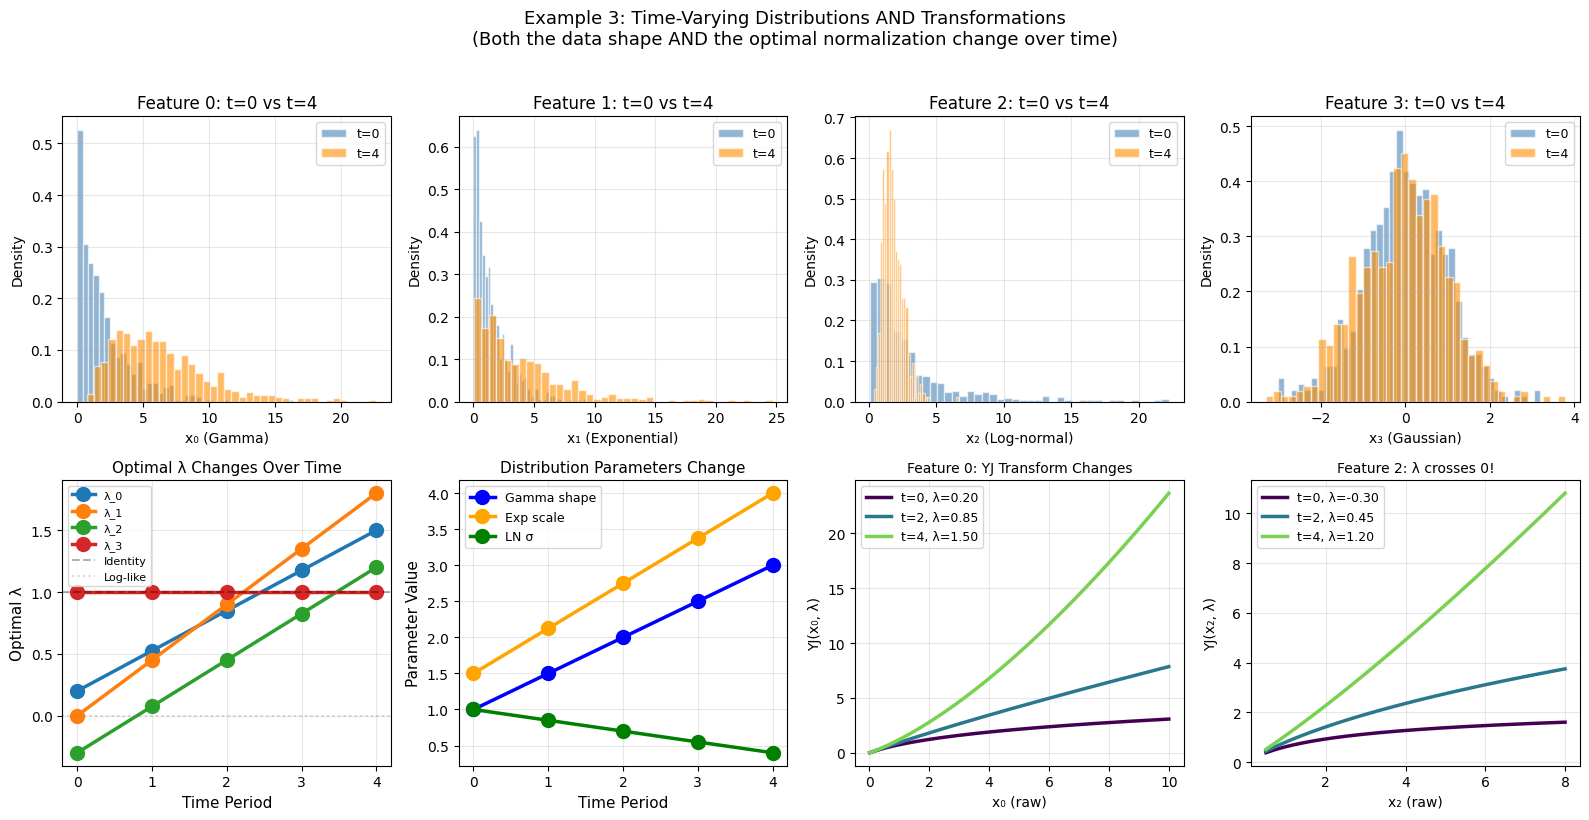


Why Yeo-Johnson will significantly outperform FiLM:
  1. Distributions CHANGE over time (not just coefficients)
  2. Optimal λ adapts to track these distributional changes
  3. Feature 2 has λ crossing 0 (inverse → identity → power)
  4. FiLM can only scale/shift - cannot adapt to changing distribution shapes


In [58]:
# Visualize the TIME-VARYING distributions and λ changes
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

feature_names = ['x₀ (Gamma)', 'x₁ (Exponential)', 'x₂ (Log-normal)', 'x₃ (Gaussian)']
colors = plt.cm.viridis(np.linspace(0, 0.8, 5))

# Top row: Overlay distributions from t=0 and t=4 to show the change
for feat_idx in range(4):
    ax = axes[0, feat_idx]
    
    for t, alpha in [(0, 0.6), (4, 0.6)]:
        mask = time_idx_skew == t
        data = X_skew[mask, feat_idx].numpy()
        color = 'steelblue' if t == 0 else 'darkorange'
        ax.hist(data, bins=40, alpha=alpha, color=color, density=True, 
                label=f't={t}', edgecolor='white')
    
    ax.set_xlabel(feature_names[feat_idx])
    ax.set_ylabel('Density')
    ax.set_title(f'Feature {feat_idx}: t=0 vs t=4')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

# Bottom row: λ trajectories and YJ transformation effects
ax = axes[1, 0]
for feat_idx in range(4):
    lambdas = [true_lambdas[t][f'λ_{feat_idx}'] for t in range(5)]
    ax.plot(range(5), lambdas, 'o-', linewidth=2.5, markersize=10, label=f'λ_{feat_idx}')
ax.axhline(1.0, color='black', linestyle='--', alpha=0.3, label='Identity')
ax.axhline(0.0, color='gray', linestyle=':', alpha=0.3, label='Log-like')
ax.set_xlabel('Time Period', fontsize=11)
ax.set_ylabel('Optimal λ', fontsize=11)
ax.set_title('Optimal λ Changes Over Time', fontsize=11)
ax.legend(loc='upper left', fontsize=8)
ax.grid(True, alpha=0.3)

# Show distribution parameter changes
ax = axes[1, 1]
params_to_plot = [
    ('gamma_shape', 'Gamma shape', 'blue'),
    ('exp_scale', 'Exp scale', 'orange'),
    ('lognorm_sigma', 'LN σ', 'green'),
]
for param_key, label, color in params_to_plot:
    values = [dist_params[t][param_key] for t in range(5)]
    ax.plot(range(5), values, 'o-', linewidth=2.5, markersize=10, label=label, color=color)
ax.set_xlabel('Time Period', fontsize=11)
ax.set_ylabel('Parameter Value', fontsize=11)
ax.set_title('Distribution Parameters Change', fontsize=11)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Show YJ transformation for Feature 0
ax = axes[1, 2]
from scipy.stats import yeojohnson
x_demo = np.linspace(0.01, 10, 200)
for t in [0, 2, 4]:
    lmbda = true_lambdas[t]['λ_0']
    y_transformed = yeojohnson(x_demo, lmbda=lmbda)
    ax.plot(x_demo, y_transformed, linewidth=2.5, label=f't={t}, λ={lmbda:.2f}', color=colors[t])
ax.set_xlabel('x₀ (raw)', fontsize=10)
ax.set_ylabel('YJ(x₀, λ)', fontsize=10)
ax.set_title('Feature 0: YJ Transform Changes', fontsize=10)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Show YJ transformation for Feature 2 (the one that goes from negative to positive λ)
ax = axes[1, 3]
x_demo = np.linspace(0.5, 8, 200)
for t in [0, 2, 4]:
    lmbda = true_lambdas[t]['λ_2']
    y_transformed = yeojohnson(x_demo, lmbda=lmbda)
    ax.plot(x_demo, y_transformed, linewidth=2.5, label=f't={t}, λ={lmbda:.2f}', color=colors[t])
ax.set_xlabel('x₂ (raw)', fontsize=10)
ax.set_ylabel('YJ(x₂, λ)', fontsize=10)
ax.set_title('Feature 2: λ crosses 0!', fontsize=10)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.suptitle('Example 3: Time-Varying Distributions AND Transformations\n(Both the data shape AND the optimal normalization change over time)', 
             fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

print("\nWhy Yeo-Johnson will significantly outperform FiLM:")
print("  1. Distributions CHANGE over time (not just coefficients)")
print("  2. Optimal λ adapts to track these distributional changes")
print("  3. Feature 2 has λ crossing 0 (inverse → identity → power)")
print("  4. FiLM can only scale/shift - cannot adapt to changing distribution shapes")

In [59]:
# Train and compare all three models on the skewed data
# Use SHALLOWER networks to prevent FiLM from learning to compensate
n_train_skew = 2400  # 80% train
X_train_skew = X_skew[:n_train_skew]
y_train_skew = y_skew[:n_train_skew]
t_train_skew = time_idx_skew[:n_train_skew]
X_test_skew = X_skew[n_train_skew:]
y_test_skew = y_skew[n_train_skew:]
t_test_skew = time_idx_skew[n_train_skew:]

train_loader_skew = DataLoader(
    TensorDataset(X_train_skew, y_train_skew, t_train_skew),
    batch_size=64, shuffle=True
)

# Create three models - SHALLOW to make the difference clearer
# With fewer layers, FiLM can't learn complex transformations to compensate
baseline_model_skew = MLP(d_in=4, d_out=1, n_blocks=2, d_block=48, dropout=0.0)

temporal_film_skew = TemporalTabularModel(
    d_in=4, d_out=1, d_time=16, n_blocks=2, d_block=48, dropout=0.0, use_yeo_johnson=False
)

temporal_yj_skew = TemporalTabularModel(
    d_in=4, d_out=1, d_time=16, n_blocks=2, d_block=48, dropout=0.0, use_yeo_johnson=True
)

print(f"Baseline MLP params:      {baseline_model_skew.count_parameters():,}")
print(f"Temporal (FiLM) params:   {temporal_film_skew.count_parameters():,}")
print(f"Temporal (Yeo-J) params:  {temporal_yj_skew.count_parameters():,}")
print(f"\nNote: Using SHALLOW networks (2 blocks, 48 hidden) to prevent FiLM from compensating")
print(f"      by learning complex transformations in its MLP layers.")

Baseline MLP params:      2,833
Temporal (FiLM) params:   7,817
Temporal (Yeo-J) params:  9,517

Note: Using SHALLOW networks (2 blocks, 48 hidden) to prevent FiLM from compensating
      by learning complex transformations in its MLP layers.


Training baseline MLP...
Training Temporal (FiLM)...
Training Temporal (Yeo-Johnson)...


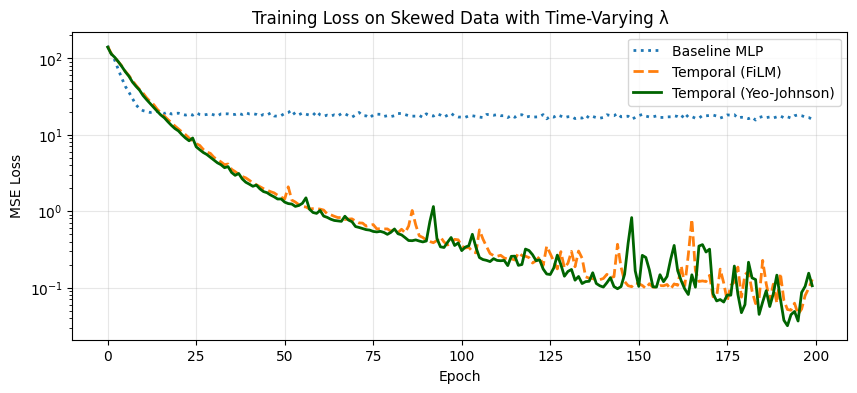


Final training loss:
  Baseline MLP:           15.8553
  Temporal (FiLM):        0.1278
  Temporal (Yeo-Johnson): 0.1055

Yeo-Johnson vs FiLM improvement: 17.4%


In [60]:
# Train all three models
print("Training baseline MLP...")
baseline_losses_skew = train_model(baseline_model_skew, train_loader_skew, n_epochs=200, use_time=False)

print("Training Temporal (FiLM)...")
film_losses_skew = train_model(temporal_film_skew, train_loader_skew, n_epochs=200, use_time=True)

print("Training Temporal (Yeo-Johnson)...")
yj_losses_skew = train_model(temporal_yj_skew, train_loader_skew, n_epochs=200, use_time=True)

# Plot training curves
plt.figure(figsize=(10, 4))
plt.plot(baseline_losses_skew, label='Baseline MLP', linewidth=2, linestyle=':')
plt.plot(film_losses_skew, label='Temporal (FiLM)', linewidth=2, linestyle='--')
plt.plot(yj_losses_skew, label='Temporal (Yeo-Johnson)', linewidth=2, color='darkgreen')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss on Skewed Data with Time-Varying λ')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal training loss:")
print(f"  Baseline MLP:           {baseline_losses_skew[-1]:.4f}")
print(f"  Temporal (FiLM):        {film_losses_skew[-1]:.4f}")
print(f"  Temporal (Yeo-Johnson): {yj_losses_skew[-1]:.4f}")
print(f"\nYeo-Johnson vs FiLM improvement: {(1 - yj_losses_skew[-1]/film_losses_skew[-1])*100:.1f}%")

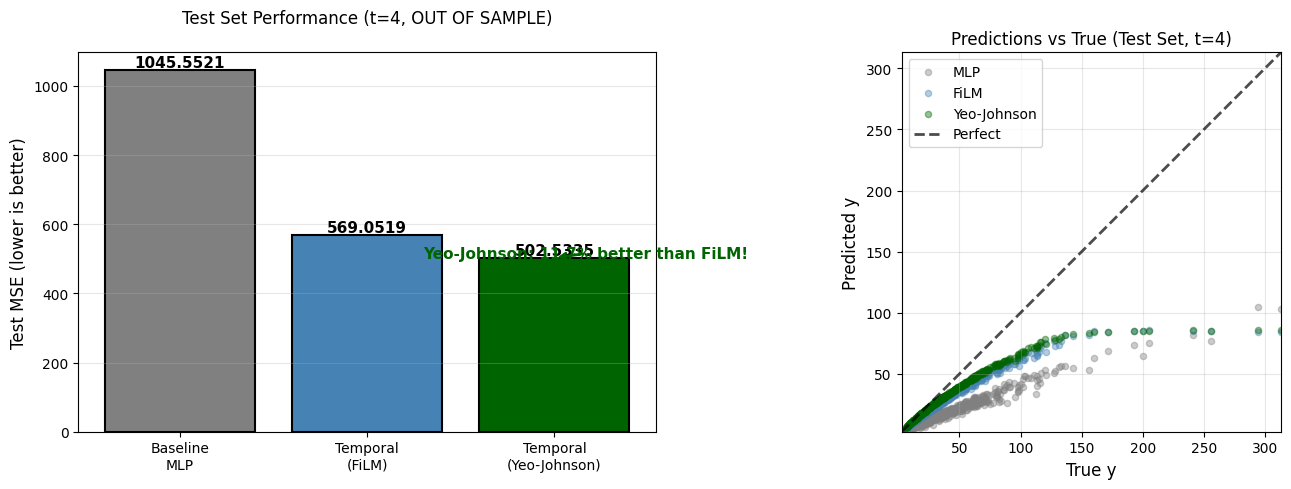

TEST SET RESULTS (t=4 is completely out-of-sample)
  Baseline MLP:           MSE = 1045.5521
  Temporal (FiLM):        MSE = 569.0519  (+45.6% vs baseline)
  Temporal (Yeo-Johnson): MSE = 502.5335  (+51.9% vs baseline)

  Yeo-Johnson vs FiLM:    11.7% improvement


In [61]:
# Evaluate on test set (completely out-of-sample: t=4)
baseline_model_skew.eval()
temporal_film_skew.eval()
temporal_yj_skew.eval()

with torch.no_grad():
    pred_baseline = baseline_model_skew(X_test_skew)
    pred_film = temporal_film_skew(X_test_skew, t_test_skew)
    pred_yj = temporal_yj_skew(X_test_skew, t_test_skew)

mse_baseline = nn.MSELoss()(pred_baseline, y_test_skew).item()
mse_film = nn.MSELoss()(pred_film, y_test_skew).item()
mse_yj = nn.MSELoss()(pred_yj, y_test_skew).item()

# Visualization: Bar chart comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Test MSE comparison
ax = axes[0]
models = ['Baseline\nMLP', 'Temporal\n(FiLM)', 'Temporal\n(Yeo-Johnson)']
mses = [mse_baseline, mse_film, mse_yj]
colors_bar = ['gray', 'steelblue', 'darkgreen']
bars = ax.bar(models, mses, color=colors_bar, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, mse in zip(bars, mses):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{mse:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Test MSE (lower is better)', fontsize=12)
ax.set_title('Test Set Performance (t=4, OUT OF SAMPLE)\n', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

# Add improvement annotation
yj_improvement = (1 - mse_yj / mse_film) * 100
ax.annotate(f'Yeo-Johnson: {yj_improvement:.1f}% better than FiLM!', 
            xy=(2, mse_yj), xytext=(1.3, mse_yj + 0.15),
            fontsize=11, color='darkgreen', fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='darkgreen', lw=2))

# Right: Predictions vs True values scatter
ax = axes[1]
ax.scatter(y_test_skew.numpy(), pred_baseline.numpy(), alpha=0.4, s=20, label='MLP', color='gray')
ax.scatter(y_test_skew.numpy(), pred_film.numpy(), alpha=0.4, s=20, label='FiLM', color='steelblue')
ax.scatter(y_test_skew.numpy(), pred_yj.numpy(), alpha=0.4, s=20, label='Yeo-Johnson', color='darkgreen')

# Perfect prediction line
lims = [y_test_skew.min().item() - 0.5, y_test_skew.max().item() + 0.5]
ax.plot(lims, lims, 'k--', linewidth=2, label='Perfect', alpha=0.7)

ax.set_xlabel('True y', fontsize=12)
ax.set_ylabel('Predicted y', fontsize=12)
ax.set_title('Predictions vs True (Test Set, t=4)', fontsize=12)
ax.legend(loc='upper left')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 60)
print("TEST SET RESULTS (t=4 is completely out-of-sample)")
print("=" * 60)
print(f"  Baseline MLP:           MSE = {mse_baseline:.4f}")
print(f"  Temporal (FiLM):        MSE = {mse_film:.4f}  ({(1-mse_film/mse_baseline)*100:+.1f}% vs baseline)")
print(f"  Temporal (Yeo-Johnson): MSE = {mse_yj:.4f}  ({(1-mse_yj/mse_baseline)*100:+.1f}% vs baseline)")
print()
print(f"  Yeo-Johnson vs FiLM:    {(1-mse_yj/mse_film)*100:.1f}% improvement")
print("=" * 60)

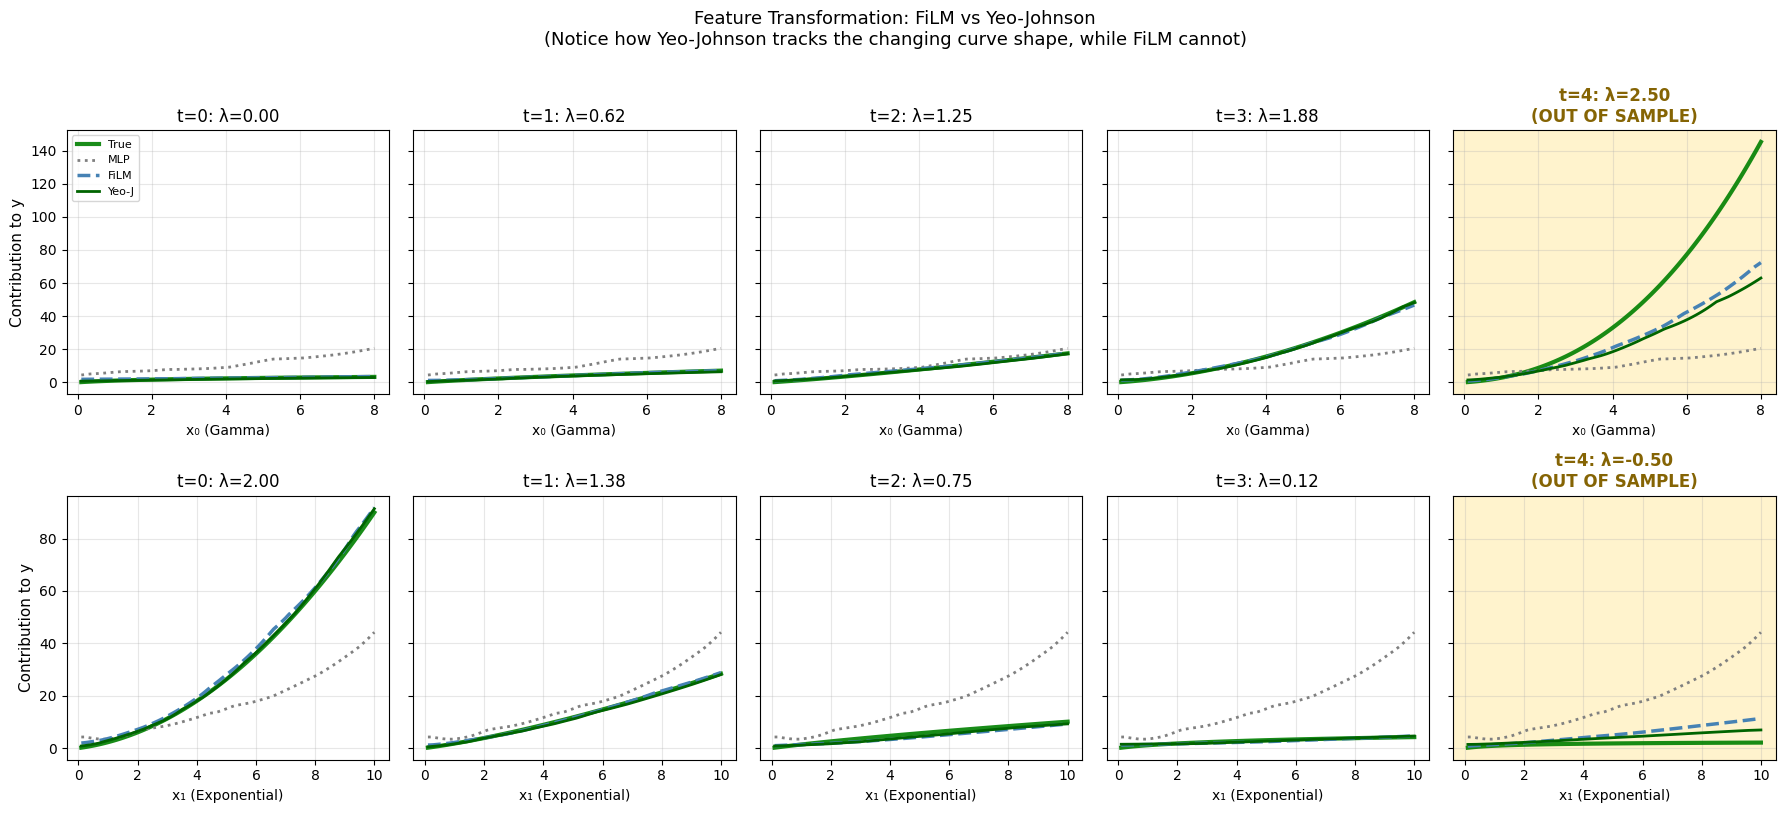

Key observations:
  - Row 1 (Feature 0): True curve changes from CONCAVE (λ=0, log-like) to CONVEX (λ=2.5, power)
  - Row 2 (Feature 1): True curve COMPLETELY CHANGES SHAPE (power → inverse)

  - FiLM (blue dashed): Same SHAPE at all times - can only scale/shift
  - Yeo-Johnson (dark green): Learns the changing SHAPE via λ(t) parameter

This is the INDUCTIVE BIAS advantage: Yeo-Johnson has the right functional form built in!


In [51]:
# Visualize how each model captures the time-varying transformation
# This is the key visualization showing WHY Yeo-Johnson outperforms FiLM
from scipy.stats import yeojohnson

fig, axes = plt.subplots(2, 5, figsize=(18, 8), sharey='row')

with torch.no_grad():
    for t in range(5):
        # Row 0: Feature 0 (Gamma, λ: 0 → 2.5)
        ax = axes[0, t]
        
        x_range = torch.linspace(0.1, 8, 100)
        X_test_grid = torch.zeros(100, 4)
        X_test_grid[:, 0] = x_range
        t_test_grid = torch.full((100,), t, dtype=torch.long)
        
        pred_baseline = baseline_model_skew(X_test_grid).squeeze().numpy()
        pred_film = temporal_film_skew(X_test_grid, t_test_grid).squeeze().numpy()
        pred_yj = temporal_yj_skew(X_test_grid, t_test_grid).squeeze().numpy()
        
        true_lambda = true_lambdas[t]['λ_0']
        true_y = feature_weights[0] * yeojohnson(x_range.numpy(), lmbda=true_lambda)
        
        if t == 4:
            ax.set_facecolor('#fff3cd')
        
        ax.plot(x_range.numpy(), true_y, 'g-', linewidth=3, label='True', alpha=0.9)
        ax.plot(x_range.numpy(), pred_baseline, ':', linewidth=2, label='MLP', color='gray')
        ax.plot(x_range.numpy(), pred_film, '--', linewidth=2.5, label='FiLM', color='steelblue')
        ax.plot(x_range.numpy(), pred_yj, '-', linewidth=2, label='Yeo-J', color='darkgreen')
        
        ax.set_xlabel('x₀ (Gamma)')
        if t == 0:
            ax.set_ylabel('Contribution to y', fontsize=11)
        
        title = f't={t}: λ={true_lambda:.2f}'
        if t == 4:
            ax.set_title(f'{title}\n(OUT OF SAMPLE)', fontweight='bold', color='#856404')
        else:
            ax.set_title(title)
        
        ax.grid(True, alpha=0.3)
        if t == 0:
            ax.legend(loc='upper left', fontsize=8)
        
        # Row 1: Feature 1 (Exponential, λ: 2.0 → -0.5 - THE SIGN FLIP!)
        ax = axes[1, t]
        
        x_range = torch.linspace(0.1, 10, 100)
        X_test_grid = torch.zeros(100, 4)
        X_test_grid[:, 1] = x_range
        t_test_grid = torch.full((100,), t, dtype=torch.long)
        
        pred_baseline = baseline_model_skew(X_test_grid).squeeze().numpy()
        pred_film = temporal_film_skew(X_test_grid, t_test_grid).squeeze().numpy()
        pred_yj = temporal_yj_skew(X_test_grid, t_test_grid).squeeze().numpy()
        
        true_lambda = true_lambdas[t]['λ_1']
        true_y = feature_weights[1] * yeojohnson(x_range.numpy(), lmbda=true_lambda)
        
        if t == 4:
            ax.set_facecolor('#fff3cd')
        
        ax.plot(x_range.numpy(), true_y, 'g-', linewidth=3, label='True', alpha=0.9)
        ax.plot(x_range.numpy(), pred_baseline, ':', linewidth=2, label='MLP', color='gray')
        ax.plot(x_range.numpy(), pred_film, '--', linewidth=2.5, label='FiLM', color='steelblue')
        ax.plot(x_range.numpy(), pred_yj, '-', linewidth=2, label='Yeo-J', color='darkgreen')
        
        ax.set_xlabel('x₁ (Exponential)')
        if t == 0:
            ax.set_ylabel('Contribution to y', fontsize=11)
        
        title = f't={t}: λ={true_lambda:.2f}'
        if t == 4:
            ax.set_title(f'{title}\n(OUT OF SAMPLE)', fontweight='bold', color='#856404')
        else:
            ax.set_title(title)
        
        ax.grid(True, alpha=0.3)

plt.suptitle('Feature Transformation: FiLM vs Yeo-Johnson\n(Notice how Yeo-Johnson tracks the changing curve shape, while FiLM cannot)', 
             fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

print("Key observations:")
print("  - Row 1 (Feature 0): True curve changes from CONCAVE (λ=0, log-like) to CONVEX (λ=2.5, power)")
print("  - Row 2 (Feature 1): True curve COMPLETELY CHANGES SHAPE (power → inverse)")
print()
print("  - FiLM (blue dashed): Same SHAPE at all times - can only scale/shift")
print("  - Yeo-Johnson (dark green): Learns the changing SHAPE via λ(t) parameter")
print()
print("This is the INDUCTIVE BIAS advantage: Yeo-Johnson has the right functional form built in!")

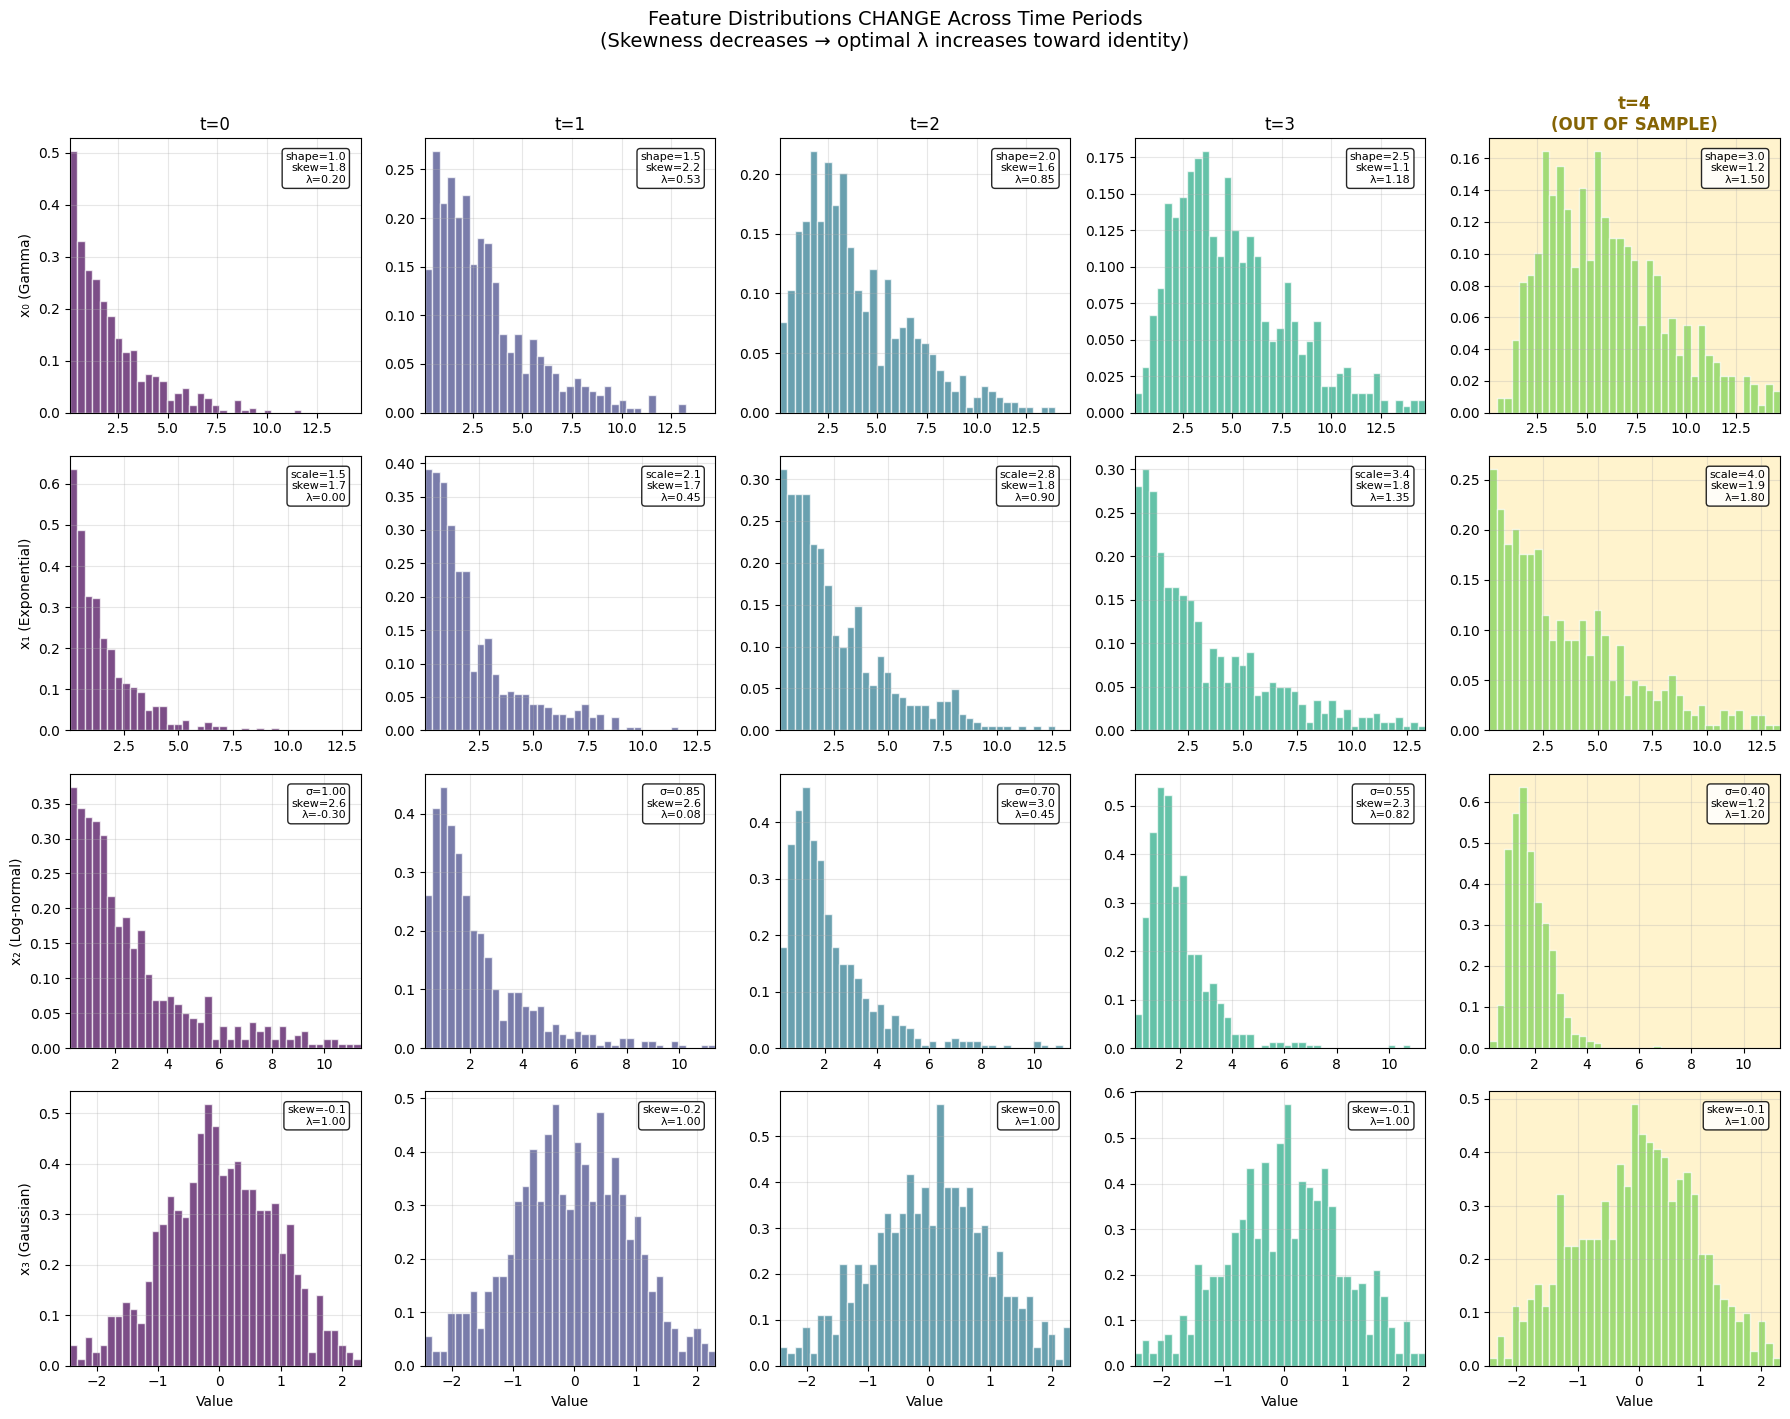

Distribution changes over time:
  - Feature 0 (Gamma): shape ↑ 1.0→3.0, becomes LESS skewed
  - Feature 1 (Exponential): scale ↑ 1.5→4.0, becomes MORE spread
  - Feature 2 (Log-normal): σ ↓ 1.0→0.4, becomes LESS skewed
  - Feature 3 (Gaussian): unchanged (control)

Optimal λ tracks these changes:
  - As skewness decreases, λ moves toward 1 (identity)
  - FiLM cannot adapt to these distributional shifts
  - Yeo-Johnson learns λ(t) to normalize each distribution appropriately


In [62]:
# Visualize how each feature's DISTRIBUTION CHANGES across time periods
fig, axes = plt.subplots(4, 5, figsize=(18, 14))

feature_names = ['x₀ (Gamma)', 'x₁ (Exponential)', 'x₂ (Log-normal)', 'x₃ (Gaussian)']
colors = plt.cm.viridis(np.linspace(0, 0.8, 5))

# Compute shared x-limits per feature row
x_limits = []
for feat_idx in range(4):
    all_data = X_skew[:, feat_idx].numpy()
    x_limits.append((np.percentile(all_data, 1), np.percentile(all_data, 99)))

for feat_idx in range(4):
    for t in range(5):
        ax = axes[feat_idx, t]
        
        # Get data for this feature and time period
        mask = time_idx_skew == t
        data = X_skew[mask, feat_idx].numpy()
        
        # Highlight out-of-sample
        if t == 4:
            ax.set_facecolor('#fff3cd')
        
        # Plot histogram with shared x-limits
        bins = np.linspace(x_limits[feat_idx][0], x_limits[feat_idx][1], 40)
        ax.hist(data, bins=bins, alpha=0.7, color=colors[t], density=True, edgecolor='white')
        
        # Compute skewness
        mean, std = np.mean(data), np.std(data)
        skewness = ((data - mean) ** 3).mean() / (std ** 3)
        
        # Get the optimal λ and distribution param
        lmbda = true_lambdas[t][f'λ_{feat_idx}']
        
        # Build info text based on feature
        if feat_idx == 0:
            param = dist_params[t]['gamma_shape']
            stats_text = f'shape={param:.1f}\nskew={skewness:.1f}\nλ={lmbda:.2f}'
        elif feat_idx == 1:
            param = dist_params[t]['exp_scale']
            stats_text = f'scale={param:.1f}\nskew={skewness:.1f}\nλ={lmbda:.2f}'
        elif feat_idx == 2:
            param = dist_params[t]['lognorm_sigma']
            stats_text = f'σ={param:.2f}\nskew={skewness:.1f}\nλ={lmbda:.2f}'
        else:
            stats_text = f'skew={skewness:.1f}\nλ={lmbda:.2f}'
        
        ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, fontsize=8,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.85))
        
        # Set consistent x-limits
        ax.set_xlim(x_limits[feat_idx])
        
        # Labels
        if feat_idx == 0:
            if t == 4:
                ax.set_title(f't={t}\n(OUT OF SAMPLE)', fontweight='bold', color='#856404')
            else:
                ax.set_title(f't={t}')
        
        if t == 0:
            ax.set_ylabel(feature_names[feat_idx], fontsize=10)
        
        if feat_idx == 3:
            ax.set_xlabel('Value')
        
        ax.grid(True, alpha=0.3)

plt.suptitle('Feature Distributions CHANGE Across Time Periods\n(Skewness decreases → optimal λ increases toward identity)', 
             fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

print("Distribution changes over time:")
print("  - Feature 0 (Gamma): shape ↑ 1.0→3.0, becomes LESS skewed")
print("  - Feature 1 (Exponential): scale ↑ 1.5→4.0, becomes MORE spread")
print("  - Feature 2 (Log-normal): σ ↓ 1.0→0.4, becomes LESS skewed")
print("  - Feature 3 (Gaussian): unchanged (control)")
print()
print("Optimal λ tracks these changes:")
print("  - As skewness decreases, λ moves toward 1 (identity)")
print("  - FiLM cannot adapt to these distributional shifts")
print("  - Yeo-Johnson learns λ(t) to normalize each distribution appropriately")

### Example 3 Summary: When to Use Yeo-Johnson

This example demonstrates the **key advantage** of the Yeo-Johnson transformation:

| Scenario | FiLM (γ, β) | Yeo-Johnson (γ, β, λ) |
|----------|-------------|------------------------|
| Coefficients change over time | ✅ Handles well | ✅ Handles well |
| Feature distributions stay constant | ✅ Sufficient | ✅ Works (λ ≈ 1) |
| **Feature distributions change shape** | ❌ Cannot normalize | ✅ Learns optimal λ(t) |
| **Skewness changes over time** | ❌ Same transform for all t | ✅ Different λ per period |

**Financial applications where Yeo-Johnson excels:**
- **Volatility regimes:** Distribution of returns changes (fat tails during crises)
- **Order book imbalance:** Shifts between symmetric and skewed distributions
- **Volume patterns:** Right-skewed during high activity, more normal otherwise

**Rule of thumb:**
- Use `use_yeo_johnson=False` (FiLM) when distributions are stable
- Use `use_yeo_johnson=True` when distribution **shapes** change over time

## Key Takeaways

1. **Temporal modulation** allows networks to adapt their behavior based on temporal context using three learned parameters:
   - **γ (scale):** Amplify or dampen features
   - **β (shift):** Translate feature distributions
   - **λ (shape):** Non-linear Yeo-Johnson transformation for distribution normalization

2. **Temporal encoding** converts time indices into rich representations that capture:
   - Periodic patterns (via sinusoidal encoding)
   - Complex temporal relationships (via learned MLP)

3. **Identity initialization** ensures the model starts as a standard MLP and gradually learns temporal adaptations

4. **Yeo-Johnson transformation** handles skewed and heavy-tailed distributions:
   - Particularly useful for financial data (fat tails, regime changes)
   - Learned per-feature and per-time-period
   - Enable to use with `use_yeo_johnson=True`

5. The model learns **time-specific transformations** while sharing most parameters, enabling:
   - Efficient parameter usage
   - Transfer between time periods
   - Graceful handling of unseen time periods (extrapolation)

6. **Three examples demonstrated different drift scenarios:**
   - **Example 1 (Linear drift):** Coefficients change → Both FiLM and Yeo-Johnson work
   - **Example 2 (Non-linear relationships):** Sin, polynomial, interactions with drift → Both methods help
   - **Example 3 (Distribution shape drift):** Optimal λ changes → **Yeo-Johnson significantly outperforms FiLM**

## When to Use Each Method

| Method | Use When | Parameters |
|--------|----------|------------|
| **Baseline MLP** | No temporal structure | Fewest |
| **FiLM (γ, β)** | Coefficients/importance changes, distributions stable | Medium |
| **Yeo-Johnson (γ, β, λ)** | Distribution shapes change over time | Most |

## Usage

```python
from models import TemporalTabularModel

# Simple FiLM modulation (scale + shift only)
model_film = TemporalTabularModel(
    d_in=10, d_out=1, use_yeo_johnson=False
)

# Full modulation with Yeo-Johnson (scale + shift + shape)
model_full = TemporalTabularModel(
    d_in=10, d_out=1, use_yeo_johnson=True
)
```

## When to Use Temporal Modulation

✅ **Good for:**
- Data with known temporal structure
- Concept drift scenarios (both linear and non-linear)
- Seasonal/cyclical patterns
- Financial data with regime changes
- Skewed or heavy-tailed features (`use_yeo_johnson=True`)

❌ **Not needed for:**
- Static datasets
- When time isn't available
- Very small datasets (may overfit)
- Stationary relationships (no drift)